In [1]:
import numpy as np
import tensorflow as tf
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from matplotlib import pyplot as plt
%matplotlib inline
import collections

In [2]:
CNPRegressionDescription = collections.namedtuple("CNPRegressionDescription", ('query', 'target_y', 'num_total_points', 'num_context_points'))

class GPCurvesReader(object):
    """Generates curves using a Gaussian Process.

    Supports vector inputs (x) and vector outputs (y). Kernel is 
    mean-squared exponential, using the x-value 12 coordinate distance scaled by
    some factor chosen randomly in a range. Outputs are independent gaussian
    processes.
    """

    def __init__(self, batch_size, max_num_context, x_size=1, y_size=1, l1_scale=0.4, sigma_scale=1.0, testing=False):
        """Creating a regression dataset of functions sampled from a GP"""
        self.batch_size = batch_size
        self.max_num_context = max_num_context
        self.x_size = x_size
        self.y_size = y_size
        self.l1_scale = l1_scale
        self.sigma_scale = sigma_scale
        self.testing = testing

    def gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        """Applies the Gaussian kernel to generate curve data."""
        num_total_points = tf.shape(xdata)[1]
        xdata1 = tf.expand_dims(xdata, axis=1)  # [B, 1, num_total_points, x_size]
        xdata2 = tf.expand_dims(xdata, axis=2)  # [B, num_total_points, 1, x_size]
        diff = xdata1 - xdata2  # [B, num_total_points, num_total_points, x_size]
        norm = tf.square(diff[:, None, :, :, :] / l1[:, :, None, None, :])

        norm = tf.reduce_sum(norm, -1)  # [B, y_size, num_total_points, num_total_points]
        kernel = tf.square(sigma_f)[:, :, None, None] * tf.exp(-0.5 * norm)
        kernel += (sigma_noise**2) * tf.eye(num_total_points)

        return kernel 

    def generate_curves(self):
        """Builds the op delivering the data."""
        num_context = tf.random_uniform(
            shape=[], minval=3, maxval=self.max_num_context, dtype=tf.int32)
        if self.testing:
            num_target = 400
            num_total_points = num_target
            x_values = tf.tile(tf.expand_dims(tf.range(-2., 2., 1. / 100, dtype=tf.float32), axis=0),
                  [self.batch_size, 1])
            x_values = tf.expand_dims(x_values, axis=-1)
        else:
            num_target = tf.random_uniform(shape=[], minval=2, maxval=self.max_num_context, dtype=tf.int32)
            num_total_points = num_context + num_target
            x_values = tf.random_uniform([self.batch_size, num_total_points, self.x_size], -2, 2)

        # Set the kernel parameters
        l1 = tf.ones(shape=[self.batch_size, self.y_size, self.x_size])*self.l1_scale
        sigma_f = tf.ones(shape=[self.batch_size, self.y_size])*self.sigma_scale

        kernel = self.gaussian_kernel(x_values, l1, sigma_f)

        cholesky = tf.cast(tf.cholesky(tf.cast(kernel, tf.float64)), tf.float32)

        # sample a curve
        #[B, y_size, num_total_points, 1]
        y_values = tf.matmul(cholesky, tf.random_normal([self.batch_size, self.y_size, num_total_points, 1]))

        # [batch_size, num_total_points, y_size]
        y_values = tf.transpose(tf.squeeze(y_values, 3), [0, 2, 1])

        if self.testing:
            target_x = x_values
            target_y = y_values

            # Select the observations
            idx = tf.random_shuffle(tf.range(num_target))
            context_x = tf.gather(x_values, idx[:num_context], axis=1)
            context_y = tf.gather(y_values, idx[:num_context], axis=1)
        else:
            # Select the targets which will consist of the context points as well as some new target points
            target_x = x_values[:, :num_target+num_context, :]
            target_y = y_values[:, :num_target+num_context, :]

            # Select the observations
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]


        query = ((context_x, context_y), target_x)

        return CNPRegressionDescription(
            query=query,
            target_y=target_y,
            num_total_points=tf.shape(target_x)[1],
            num_context_points=num_context)

In [3]:
# def model(data_query, num_total_points, num_context_points, target_y=None):
#     (context_x, context_y), target_x = data_query
#     encoder_input = tf.concat([context_x, context_y], axis=-1)
#     batch_size, _, filter_size = encoder_input.shape.as_list()
#     hidden = tf.reshape(encoder_input, (batch_size*num_context_points, -1))
#     hidden.set_shape((None, filter_size))

#     # Pass through MLP
#     output_size = [128,128,128,128]
#     with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
#         for i, size in enumerate(output_size):
#             hidden = tf.nn.relu(tf.layers.dense(hidden, size, name="Encoder_layer_{}".format(i)))
#         # Last layer without a relu
#         hidden = tf.layers.dense(hidden, output_size[-1], name="Encoder_layer_{}".format(i+1))

#     hidden = tf.reshape(hidden, (batch_size, num_context_points, size))

#     representation = tf.reduce_mean(hidden, axis=1)
    
#     representation = tf.tile(tf.expand_dims(representation, axis=1), [1, num_total_points, 1])
#     input = tf.concat([representation, target_x], axis=-1)

#     batch_size, _, filter_size = input.shape.as_list()
#     hidden = tf.reshape(input, (batch_size1*num_total_points,-1))
#     hidden.set_shape((None, filter_size))

#     output_size = [128,128,2]
#     with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):
#         for i, size in enumerate(output_size):
#             hidden = tf.nn.relu(tf.layers.dense(hidden, size, name="Decoder_layer_{}".format(i)))
#         hidden = tf.layers.dense(hidden, output_size[-1], name="Decoder_layer_{}".format(i+1))

#     hidden = tf.reshape(hidden, (batch_size, num_total_points, -1))

#     mu, log_sigma = tf.split(hidden, 2, axis=-1)

#     sigma = 0.1 + 0.9*tf.nn.softplus(log_sigma)

#     dist = tf.contrib.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
        
#     if target_y is not None:
# #         square_difference = tf.squared_difference(mu, target_y)

# #         log_p = -tf.div(square_difference, sigma) - tf.log(sigma)

#         log_p = dist.log_prob(target_y)
#     else:
#         log_p = None
#     return log_p, mu, sigma

In [4]:
def model(data_query, num_total_points, target_y=None):
    (context_x, context_y), decoder_input = data_query
    context_x = tf.squeeze(context_x, axis=0)
    context_y = tf.squeeze(context_y, axis=0)
    decoder_input = tf.squeeze(decoder_input, axis=0)
    hidden = tf.concat((context_x, context_y), axis=-1)
    
#     output_size = [128,128,128,128]
#     with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
#         for i, size in enumerate(output_size[:-1]):
#             hidden = tf.nn.relu(tf.layers.dense(hidden, size, name="Encoder_layer_{}".format(i)))
#         # Last layer without a relu
#         hidden = tf.layers.dense(hidden, output_size[-1], name="Encoder_layer_{}".format(i+1))
    with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
        hidden = tf.nn.relu(tf.layers.dense(hidden, 128))#,normalizer_fn=tf.contrib.layers.batch_norm)
        hidden = tf.nn.relu(tf.layers.dense(hidden, 128))#,normalizer_fn=tf.contrib.layers.batch_norm)
        hidden = tf.nn.relu(tf.layers.dense(hidden, 128))#,normalizer_fn=tf.contrib.layers.batch_norm)
        hidden = tf.layers.dense(hidden, 128)
#     encoder_layer1 = tf.contrib.layers.fully_connected(encoder_input, 128)#,normalizer_fn=tf.contrib.layers.batch_norm)
#     encoder_layer2 = tf.contrib.layers.fully_connected(encoder_layer1, 128)#,normalizer_fn=tf.contrib.layers.batch_norm)
#     encoder_layer3 = tf.contrib.layers.fully_connected(encoder_layer2, 128)#,normalizer_fn=tf.contrib.layers.batch_norm)
#     encoder_layer4 = tf.contrib.layers.fully_connected(encoder_layer3, 128,)#normalizer_fn=tf.contrib.layers.batch_norm)
#     r = tf.reduce_mean(encoder_layer4, axis= 0,keep_dims=True)
#     print(r.shape.as_list())
        
    representation = tf.reduce_mean(hidden, axis=0)
#     representation = tf.tile(representation, [num_total_points, 1])
    representation = tf.tile(tf.expand_dims(representation, axis=0), [num_total_points, 1])
    hidden = tf.concat([representation, decoder_input], axis=-1)


#     output_size = [128,128,2]
#     with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):
#         for i, size in enumerate(output_size[:-1]):
#             hidden = tf.nn.relu(tf.layers.dense(hidden, size, name="Decoder_layer_{}".format(i)))
#         hidden = tf.layers.dense(hidden, output_size[-1], name="Decoder_layer_{}".format(i+1))
#     decoder_mean, decoder_var = tf.split(hidden, 2, axis=-1)
    with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):
        hidden = tf.nn.relu(tf.layers.dense(hidden, 128))#,normalizer_fn=tf.contrib.layers.batch_norm)
        hidden = tf.nn.relu(tf.layers.dense(hidden, 128))#,normalizer_fn=tf.contrib.layers.batch_norm)
    # decoder_layer3 = tf.contrib.layers.fully_connected(decoder_layer2, 128)#,normalizer_fn=tf.contrib.layers.batch_norm)
#     decoder_mean = tf.contrib.layers.fully_connected(decoder_layer2, 1, activation_fn=None)#,normalizer_fn=tf.contrib.layers.batch_norm)
#     decoder_var = tf.contrib.layers.fully_connected(decoder_layer2, 1, activation_fn=None)#,normalizer_fn=tf.contrib.layers.batch_norm)
        decoder_mean = tf.layers.dense(hidden, 1)
        decoder_var = tf.layers.dense(hidden, 1)


# #     decoder_input = tf.placeholder(dtype=tf.float32, shape=[None, x_dim], name='decoder_input')
# #     decoder_output = tf.placeholder(dtype=tf.float32, shape = [None, y_dim], name='decoder_output')
# #     decoder_input_rows = decoder_input.shape.as_list()[0]
# #     print(decoder_input_rows)
#     r_tiled = tf.tile(r, [num_total_points, 1])
#     print('aaaa', r_tiled.shape.as_list())
#     decoder_input_con = tf.concat([decoder_input, r_tiled], 1)
    
#     decoder_layer1 = tf.nn.relu(tf.layers.dense(decoder_input_con, 128))#,normalizer_fn=tf.contrib.layers.batch_norm)
#     decoder_layer2 = tf.nn.relu(tf.layers.dense(decoder_layer1, 128))#,normalizer_fn=tf.contrib.layers.batch_norm)
#     # decoder_layer3 = tf.contrib.layers.fully_connected(decoder_layer2, 128)#,normalizer_fn=tf.contrib.layers.batch_norm)
# #     decoder_mean = tf.contrib.layers.fully_connected(decoder_layer2, 1, activation_fn=None)#,normalizer_fn=tf.contrib.layers.batch_norm)
# #     decoder_var = tf.contrib.layers.fully_connected(decoder_layer2, 1, activation_fn=None)#,normalizer_fn=tf.contrib.layers.batch_norm)
#     decoder_mean = tf.layers.dense(decoder_layer2, 1)
#     decoder_var = tf.layers.dense(decoder_layer2, 1)
    decoder_var = 0.1 + 0.9*tf.nn.softplus(decoder_var)
    if target_y is not None:
        target_y = tf.squeeze(target_y, axis=0)
        dist = tf.contrib.distributions.MultivariateNormalDiag(loc=decoder_mean, scale_diag=decoder_var)
        log_p = dist.log_prob(target_y)
    else:
        log_p = None
    return log_p, decoder_mean, decoder_var
    
        

In [5]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):
    plt.plot(target_x[0], pred_y, 'b', linewidth=2)
#     plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
    plt.fill_between(
        target_x[0, :, 0],
        pred_y[:, 0] - var[:, 0],
        pred_y[:, 0] + var[:, 0],
        alpha=0.2,
        facecolor='#65c9f7',
        interpolate=True)
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid('off')
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    plt.show()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updatin

/Users/fanfan/anaconda/envs/tf_intro/lib/python3.5/site-packages/ipykernel/__main__.py:18: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


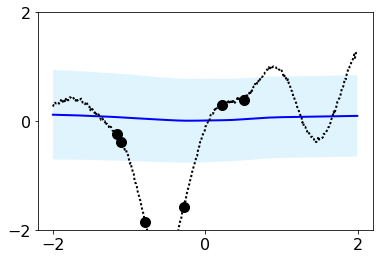

Iteration: 100, loss: 1.974745512008667
Iteration: 200, loss: 1.1474674940109253
Iteration: 300, loss: 0.8028994202613831
Iteration: 400, loss: 0.8661333322525024
Iteration: 500, loss: 1.660819411277771
Iteration: 600, loss: 1.123969316482544
Iteration: 700, loss: 1.0546144247055054
Iteration: 800, loss: 0.8907560706138611
Iteration: 900, loss: 0.6199334263801575
Iteration: 1000, loss: 0.9961907863616943
(400, 1)
(1, 400, 1)
Iteration: 1000, loss: 1.2172197103500366


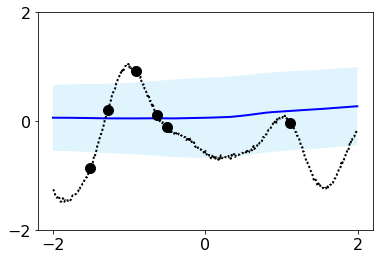

Iteration: 1100, loss: 0.8632512092590332
Iteration: 1200, loss: 1.029364824295044
Iteration: 1300, loss: 1.1830893754959106
Iteration: 1400, loss: 1.364758849143982
Iteration: 1500, loss: 0.7208303213119507
Iteration: 1600, loss: 1.20347261428833
Iteration: 1700, loss: 1.1294410228729248
Iteration: 1800, loss: 0.8529341220855713
Iteration: 1900, loss: 1.4156032800674438
Iteration: 2000, loss: 0.7051421403884888
(400, 1)
(1, 400, 1)
Iteration: 2000, loss: 1.092992901802063


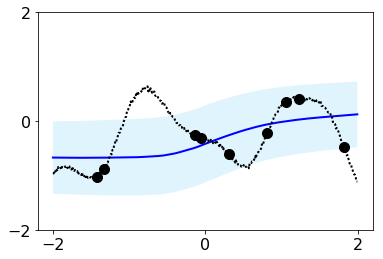

Iteration: 2100, loss: 1.027768611907959
Iteration: 2200, loss: 1.1813784837722778
Iteration: 2300, loss: 0.6025781631469727
Iteration: 2400, loss: 1.3834706544876099
Iteration: 2500, loss: 0.5674965381622314
Iteration: 2600, loss: 0.7950029373168945
Iteration: 2700, loss: 1.0498149394989014
Iteration: 2800, loss: 0.8080499172210693
Iteration: 2900, loss: 0.9808495044708252
Iteration: 3000, loss: 1.696612000465393
(400, 1)
(1, 400, 1)
Iteration: 3000, loss: 1.9837844371795654


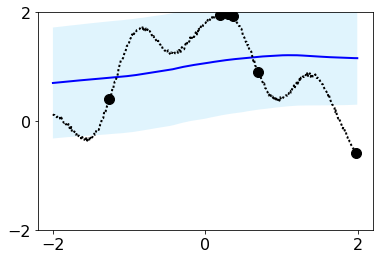

Iteration: 3100, loss: 1.1147487163543701
Iteration: 3200, loss: 1.3613779544830322
Iteration: 3300, loss: 0.9436209201812744
Iteration: 3400, loss: 1.2096173763275146
Iteration: 3500, loss: 0.7296858429908752
Iteration: 3600, loss: 0.5328041911125183
Iteration: 3700, loss: 1.6200604438781738
Iteration: 3800, loss: 0.48911306262016296
Iteration: 3900, loss: 0.975635290145874
Iteration: 4000, loss: 0.5890485048294067
(400, 1)
(1, 400, 1)
Iteration: 4000, loss: 0.8055615425109863


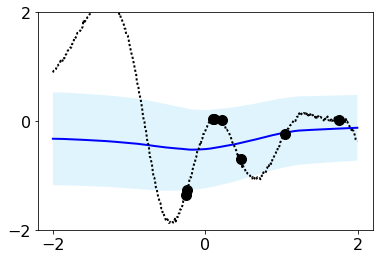

Iteration: 4100, loss: 1.1328372955322266
Iteration: 4200, loss: 0.6500667333602905
Iteration: 4300, loss: 0.7927713394165039
Iteration: 4400, loss: 2.9244720935821533
Iteration: 4500, loss: 0.6181912422180176
Iteration: 4600, loss: 0.7237496972084045
Iteration: 4700, loss: 1.0984679460525513
Iteration: 4800, loss: 1.9208984375
Iteration: 4900, loss: 0.8070438504219055
Iteration: 5000, loss: 0.7719401121139526
(400, 1)
(1, 400, 1)
Iteration: 5000, loss: 0.757386326789856


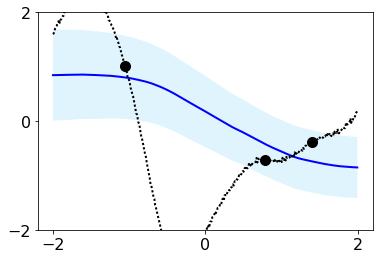

Iteration: 5100, loss: 1.1300485134124756
Iteration: 5200, loss: 0.8848495483398438
Iteration: 5300, loss: 0.6912535429000854
Iteration: 5400, loss: 0.9957813620567322
Iteration: 5500, loss: 0.6897527575492859
Iteration: 5600, loss: 0.9641366600990295
Iteration: 5700, loss: 1.0326342582702637
Iteration: 5800, loss: 0.6094768643379211
Iteration: 5900, loss: 1.3111677169799805
Iteration: 6000, loss: 1.412086009979248
(400, 1)
(1, 400, 1)
Iteration: 6000, loss: 1.545451045036316


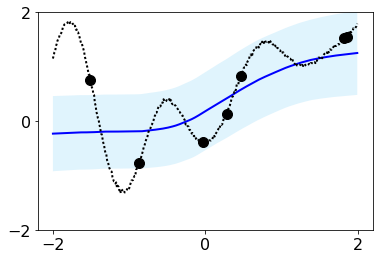

Iteration: 6100, loss: 0.8502964973449707
Iteration: 6200, loss: 0.6685226559638977
Iteration: 6300, loss: 1.0662933588027954
Iteration: 6400, loss: 0.615669846534729
Iteration: 6500, loss: 0.8997671604156494
Iteration: 6600, loss: 0.89435213804245
Iteration: 6700, loss: 1.0532150268554688
Iteration: 6800, loss: 1.086489200592041
Iteration: 6900, loss: 1.3322556018829346
Iteration: 7000, loss: 0.6818036437034607
(400, 1)
(1, 400, 1)
Iteration: 7000, loss: 1.074981927871704


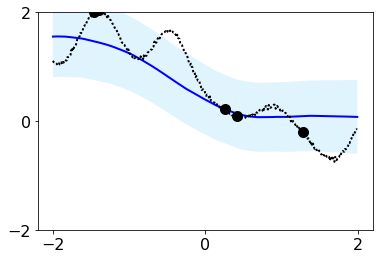

Iteration: 7100, loss: 1.4269168376922607
Iteration: 7200, loss: 0.45172277092933655
Iteration: 7300, loss: 0.9795064926147461
Iteration: 7400, loss: 1.2069737911224365
Iteration: 7500, loss: 1.385503888130188
Iteration: 7600, loss: 1.0717568397521973
Iteration: 7700, loss: 0.42086732387542725
Iteration: 7800, loss: 1.4633666276931763
Iteration: 7900, loss: 1.2470755577087402
Iteration: 8000, loss: 0.6827410459518433
(400, 1)
(1, 400, 1)
Iteration: 8000, loss: 0.9070824980735779


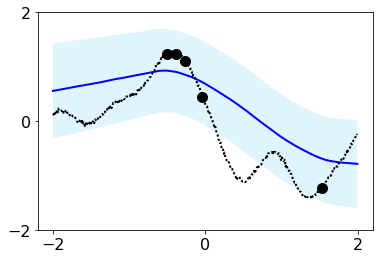

Iteration: 8100, loss: 1.2591509819030762
Iteration: 8200, loss: 0.8864867091178894
Iteration: 8300, loss: 1.3955694437026978
Iteration: 8400, loss: 1.2600659132003784
Iteration: 8500, loss: 1.3079431056976318
Iteration: 8600, loss: 0.9741157293319702
Iteration: 8700, loss: 0.7585943341255188
Iteration: 8800, loss: 1.5540134906768799
Iteration: 8900, loss: 0.797327995300293
Iteration: 9000, loss: 1.3080819845199585
(400, 1)
(1, 400, 1)
Iteration: 9000, loss: 1.7185556888580322


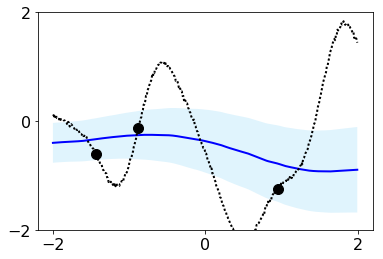

Iteration: 9100, loss: 1.458044171333313
Iteration: 9200, loss: 1.7328308820724487
Iteration: 9300, loss: 1.506422996520996
Iteration: 9400, loss: 0.9635809659957886
Iteration: 9500, loss: 0.6045395135879517
Iteration: 9600, loss: 0.7288142442703247
Iteration: 9700, loss: 1.2673789262771606
Iteration: 9800, loss: 1.0764113664627075
Iteration: 9900, loss: 0.6668949127197266
Iteration: 10000, loss: 0.7598809599876404
(400, 1)
(1, 400, 1)
Iteration: 10000, loss: 2.102796792984009


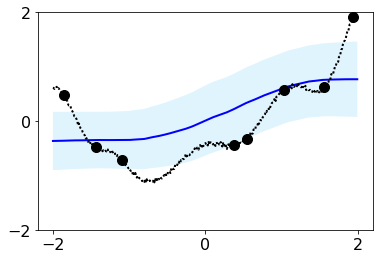

Iteration: 10100, loss: 0.540087878704071
Iteration: 10200, loss: 0.6986131072044373
Iteration: 10300, loss: 1.2154457569122314
Iteration: 10400, loss: 1.4579572677612305
Iteration: 10500, loss: 0.7095216512680054
Iteration: 10600, loss: 0.8233891725540161
Iteration: 10700, loss: 0.41266417503356934
Iteration: 10800, loss: 1.2921233177185059
Iteration: 10900, loss: 1.4827474355697632
Iteration: 11000, loss: 0.7040918469429016
(400, 1)
(1, 400, 1)
Iteration: 11000, loss: 1.2729277610778809


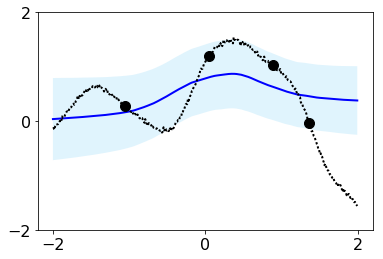

Iteration: 11100, loss: 1.3278533220291138
Iteration: 11200, loss: 0.8287560343742371
Iteration: 11300, loss: 0.42899858951568604
Iteration: 11400, loss: 0.8874684572219849
Iteration: 11500, loss: 0.46081724762916565
Iteration: 11600, loss: 0.6653227210044861
Iteration: 11700, loss: 0.9208919405937195
Iteration: 11800, loss: 0.9890967607498169
Iteration: 11900, loss: 0.4925493597984314
Iteration: 12000, loss: 1.392697811126709
(400, 1)
(1, 400, 1)
Iteration: 12000, loss: 0.7724848389625549


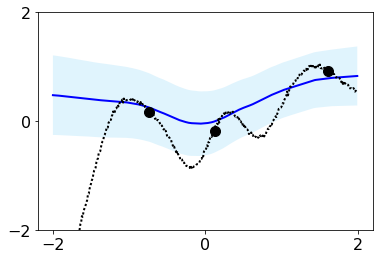

Iteration: 12100, loss: 0.6435245871543884
Iteration: 12200, loss: 0.8289420008659363
Iteration: 12300, loss: 2.050041675567627
Iteration: 12400, loss: 0.7484792470932007
Iteration: 12500, loss: 0.9618621468544006
Iteration: 12600, loss: 0.6337250471115112
Iteration: 12700, loss: 0.6003047823905945
Iteration: 12800, loss: 0.800264298915863
Iteration: 12900, loss: 1.3228278160095215
Iteration: 13000, loss: 1.1205331087112427
(400, 1)
(1, 400, 1)
Iteration: 13000, loss: 1.055745244026184


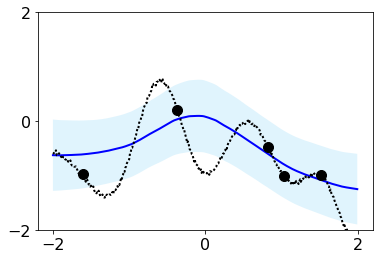

Iteration: 13100, loss: 0.7258430123329163
Iteration: 13200, loss: 2.571514129638672
Iteration: 13300, loss: 1.094419240951538
Iteration: 13400, loss: 0.47596409916877747
Iteration: 13500, loss: 0.6353641152381897
Iteration: 13600, loss: 0.954190194606781
Iteration: 13700, loss: 0.4302206039428711
Iteration: 13800, loss: 0.6435850858688354
Iteration: 13900, loss: 1.0127246379852295
Iteration: 14000, loss: 1.0966547727584839
(400, 1)
(1, 400, 1)
Iteration: 14000, loss: 0.5429086089134216


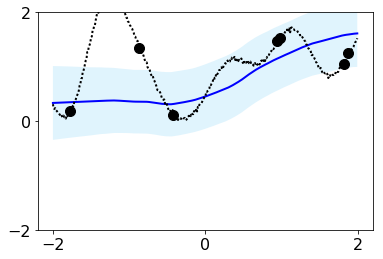

Iteration: 14100, loss: 0.6454972624778748
Iteration: 14200, loss: 0.6094418168067932
Iteration: 14300, loss: 0.7572940587997437
Iteration: 14400, loss: 0.5617407560348511
Iteration: 14500, loss: 0.5308241248130798
Iteration: 14600, loss: 1.4598057270050049
Iteration: 14700, loss: 0.5042093992233276
Iteration: 14800, loss: 0.9771458506584167
Iteration: 14900, loss: 0.7979664206504822
Iteration: 15000, loss: 0.9578627347946167
(400, 1)
(1, 400, 1)
Iteration: 15000, loss: 0.47554516792297363


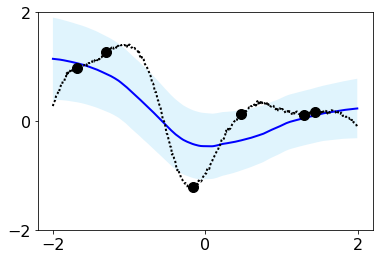

Iteration: 15100, loss: 0.8761253356933594
Iteration: 15200, loss: 1.1646040678024292
Iteration: 15300, loss: 1.8442957401275635
Iteration: 15400, loss: 1.1759371757507324
Iteration: 15500, loss: 1.2080777883529663
Iteration: 15600, loss: 0.913995087146759
Iteration: 15700, loss: 1.0653462409973145
Iteration: 15800, loss: 0.7474496960639954
Iteration: 15900, loss: 1.0440559387207031
Iteration: 16000, loss: 0.4332336485385895
(400, 1)
(1, 400, 1)
Iteration: 16000, loss: 0.5933122634887695


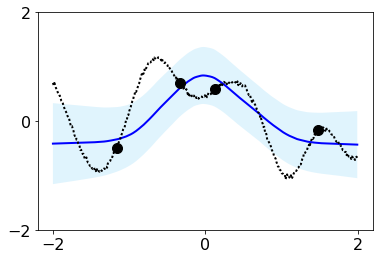

Iteration: 16100, loss: 0.9383929371833801
Iteration: 16200, loss: 1.1692652702331543
Iteration: 16300, loss: 1.159932255744934
Iteration: 16400, loss: 0.5508980751037598
Iteration: 16500, loss: 1.4385915994644165
Iteration: 16600, loss: 0.8811689615249634
Iteration: 16700, loss: 0.7961472272872925
Iteration: 16800, loss: 0.490089476108551
Iteration: 16900, loss: 1.2797508239746094
Iteration: 17000, loss: 0.8310877084732056
(400, 1)
(1, 400, 1)
Iteration: 17000, loss: 0.9854135513305664


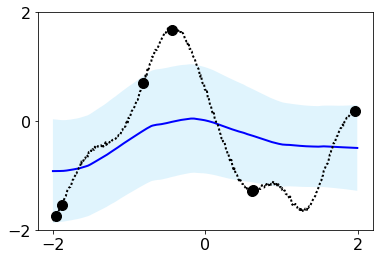

Iteration: 17100, loss: 0.400882363319397
Iteration: 17200, loss: 1.099637508392334
Iteration: 17300, loss: 0.4383693039417267
Iteration: 17400, loss: 1.302132248878479
Iteration: 17500, loss: 1.0281025171279907
Iteration: 17600, loss: 0.7737230062484741
Iteration: 17700, loss: 0.7951406240463257
Iteration: 17800, loss: 0.8709598779678345
Iteration: 17900, loss: 0.4742365777492523
Iteration: 18000, loss: 1.8243613243103027
(400, 1)
(1, 400, 1)
Iteration: 18000, loss: 1.3792270421981812


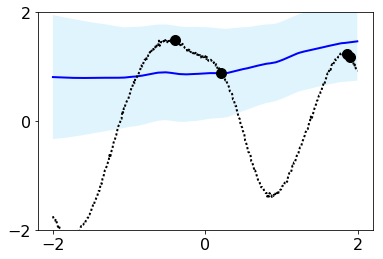

Iteration: 18100, loss: 0.9023163318634033
Iteration: 18200, loss: 1.111538052558899
Iteration: 18300, loss: 0.7166070938110352
Iteration: 18400, loss: 1.0297200679779053
Iteration: 18500, loss: 0.6134902238845825
Iteration: 18600, loss: 0.3913801312446594
Iteration: 18700, loss: 1.4929895401000977
Iteration: 18800, loss: 0.8359519243240356
Iteration: 18900, loss: 1.1454523801803589
Iteration: 19000, loss: 0.9257288575172424
(400, 1)
(1, 400, 1)
Iteration: 19000, loss: 1.1591771841049194


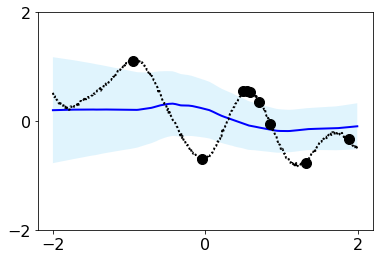

Iteration: 19100, loss: 0.5805559158325195
Iteration: 19200, loss: 0.6921895146369934
Iteration: 19300, loss: 0.8639999032020569
Iteration: 19400, loss: 0.50748211145401
Iteration: 19500, loss: 0.49891889095306396
Iteration: 19600, loss: 0.46261540055274963
Iteration: 19700, loss: 1.23841392993927
Iteration: 19800, loss: 1.104864478111267
Iteration: 19900, loss: 0.7647328972816467
Iteration: 20000, loss: 0.734503448009491
(400, 1)
(1, 400, 1)
Iteration: 20000, loss: 0.989569365978241


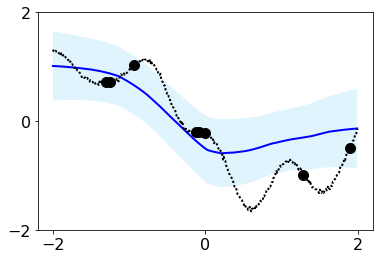

Iteration: 20100, loss: 1.4133012294769287
Iteration: 20200, loss: 1.243660569190979
Iteration: 20300, loss: 1.2995558977127075
Iteration: 20400, loss: 0.5403321981430054
Iteration: 20500, loss: 0.5122749209403992
Iteration: 20600, loss: 0.9796645045280457
Iteration: 20700, loss: 1.2547506093978882
Iteration: 20800, loss: 0.9856537580490112
Iteration: 20900, loss: 1.1616926193237305
Iteration: 21000, loss: 0.719342052936554
(400, 1)
(1, 400, 1)
Iteration: 21000, loss: 0.9793205261230469


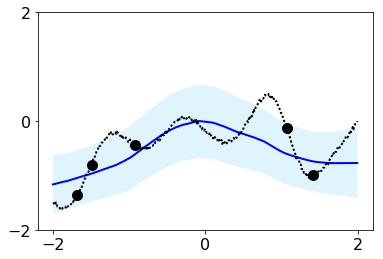

Iteration: 21100, loss: 1.6158533096313477
Iteration: 21200, loss: 1.1114277839660645
Iteration: 21300, loss: 0.8667767643928528
Iteration: 21400, loss: 1.180053949356079
Iteration: 21500, loss: 0.7648755311965942
Iteration: 21600, loss: 2.101106643676758
Iteration: 21700, loss: 0.6492589712142944
Iteration: 21800, loss: 0.8727330565452576
Iteration: 21900, loss: 1.1573586463928223
Iteration: 22000, loss: 0.5328109860420227
(400, 1)
(1, 400, 1)
Iteration: 22000, loss: 0.8134943246841431


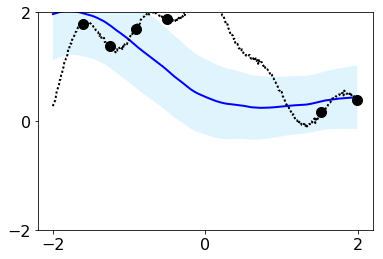

Iteration: 22100, loss: 1.9726135730743408
Iteration: 22200, loss: 1.6471689939498901
Iteration: 22300, loss: 1.4897438287734985
Iteration: 22400, loss: 0.7844736576080322
Iteration: 22500, loss: 0.7433151602745056
Iteration: 22600, loss: 0.9899848103523254
Iteration: 22700, loss: 0.7516507506370544
Iteration: 22800, loss: 0.883224368095398
Iteration: 22900, loss: 0.42735499143600464
Iteration: 23000, loss: 0.6020886898040771
(400, 1)
(1, 400, 1)
Iteration: 23000, loss: 0.950636625289917


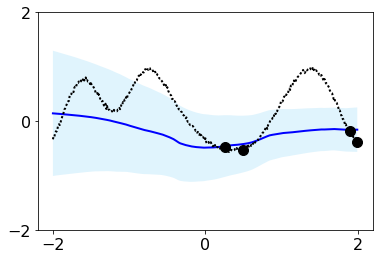

Iteration: 23100, loss: 1.0225955247879028
Iteration: 23200, loss: 0.8638240694999695
Iteration: 23300, loss: 1.2664154767990112
Iteration: 23400, loss: 1.709084391593933
Iteration: 23500, loss: 1.1733543872833252
Iteration: 23600, loss: 1.0063412189483643
Iteration: 23700, loss: 0.6957013010978699
Iteration: 23800, loss: 0.3152802288532257
Iteration: 23900, loss: 0.9615176916122437
Iteration: 24000, loss: 0.7257779836654663
(400, 1)
(1, 400, 1)
Iteration: 24000, loss: 1.1125273704528809


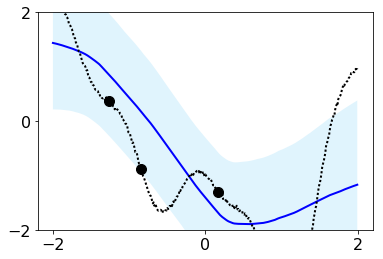

Iteration: 24100, loss: 0.9231586456298828
Iteration: 24200, loss: 0.8750276565551758
Iteration: 24300, loss: 0.35271596908569336
Iteration: 24400, loss: 1.0498417615890503
Iteration: 24500, loss: 1.2546720504760742
Iteration: 24600, loss: 0.6804807782173157
Iteration: 24700, loss: 0.6514065861701965
Iteration: 24800, loss: 0.5477681159973145
Iteration: 24900, loss: 0.7944548726081848
Iteration: 25000, loss: 0.252834290266037
(400, 1)
(1, 400, 1)
Iteration: 25000, loss: 1.5108126401901245


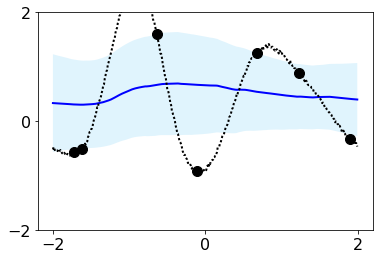

Iteration: 25100, loss: 0.5546932816505432
Iteration: 25200, loss: 1.4729654788970947
Iteration: 25300, loss: 0.6334629058837891
Iteration: 25400, loss: 0.8302318453788757
Iteration: 25500, loss: 0.4958398640155792
Iteration: 25600, loss: 0.4761818051338196
Iteration: 25700, loss: 0.7385392189025879
Iteration: 25800, loss: 0.8732811212539673
Iteration: 25900, loss: 1.6397852897644043
Iteration: 26000, loss: 0.40809166431427
(400, 1)
(1, 400, 1)
Iteration: 26000, loss: 0.48393651843070984


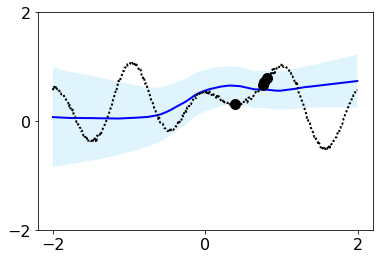

Iteration: 26100, loss: 1.169497013092041
Iteration: 26200, loss: 1.011020302772522
Iteration: 26300, loss: 0.7846596240997314
Iteration: 26400, loss: 1.494606852531433
Iteration: 26500, loss: 0.7023208737373352
Iteration: 26600, loss: 1.5720540285110474
Iteration: 26700, loss: 1.0351907014846802
Iteration: 26800, loss: 1.3708325624465942
Iteration: 26900, loss: 1.1092954874038696
Iteration: 27000, loss: 0.8742399215698242
(400, 1)
(1, 400, 1)
Iteration: 27000, loss: 0.4109090566635132


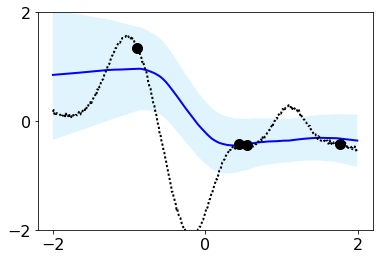

Iteration: 27100, loss: 0.8559429049491882
Iteration: 27200, loss: 1.0503156185150146
Iteration: 27300, loss: 0.7564244866371155
Iteration: 27400, loss: 0.7841744422912598
Iteration: 27500, loss: 0.5456514954566956
Iteration: 27600, loss: 0.6683281660079956
Iteration: 27700, loss: 0.9138830900192261
Iteration: 27800, loss: 0.9525015354156494
Iteration: 27900, loss: 1.1472468376159668
Iteration: 28000, loss: 1.134630799293518
(400, 1)
(1, 400, 1)
Iteration: 28000, loss: 0.6636931896209717


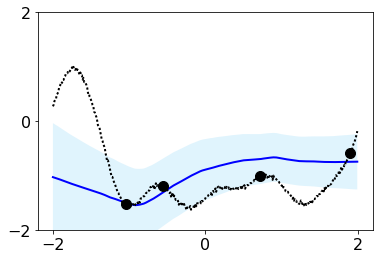

Iteration: 28100, loss: 0.7815703749656677
Iteration: 28200, loss: 0.6008442640304565
Iteration: 28300, loss: 0.461322158575058
Iteration: 28400, loss: 0.9002038240432739
Iteration: 28500, loss: 0.38947728276252747
Iteration: 28600, loss: 1.3202458620071411
Iteration: 28700, loss: 0.7554411888122559
Iteration: 28800, loss: 1.160551905632019
Iteration: 28900, loss: 0.669182538986206
Iteration: 29000, loss: 0.7633745670318604
(400, 1)
(1, 400, 1)
Iteration: 29000, loss: 1.1849430799484253


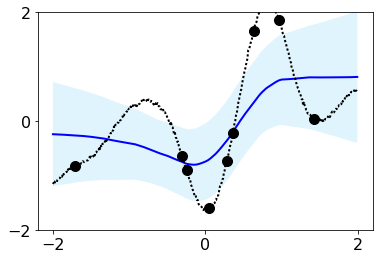

Iteration: 29100, loss: 0.6116950511932373
Iteration: 29200, loss: 0.5083555579185486
Iteration: 29300, loss: 0.9314075708389282
Iteration: 29400, loss: 0.6029776930809021
Iteration: 29500, loss: 0.9857671856880188
Iteration: 29600, loss: 0.5479959845542908
Iteration: 29700, loss: 1.2035388946533203
Iteration: 29800, loss: 0.9668825268745422
Iteration: 29900, loss: 0.8027400970458984
Iteration: 30000, loss: 1.0328726768493652
(400, 1)
(1, 400, 1)
Iteration: 30000, loss: 0.7413694858551025


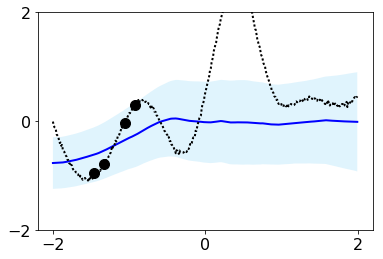

Iteration: 30100, loss: 0.8634268641471863
Iteration: 30200, loss: 0.6481403708457947
Iteration: 30300, loss: 0.4348221719264984
Iteration: 30400, loss: 1.0238138437271118
Iteration: 30500, loss: 0.7429524660110474
Iteration: 30600, loss: 1.0899676084518433
Iteration: 30700, loss: 1.158141016960144
Iteration: 30800, loss: 0.6789066195487976
Iteration: 30900, loss: 0.9691105484962463
Iteration: 31000, loss: 0.7774626612663269
(400, 1)
(1, 400, 1)
Iteration: 31000, loss: 0.8681809306144714


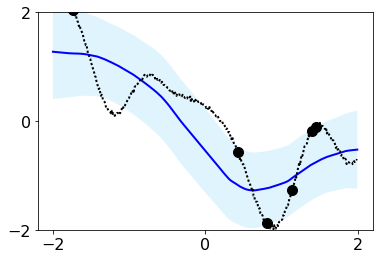

Iteration: 31100, loss: 0.6576285362243652
Iteration: 31200, loss: 1.8164620399475098
Iteration: 31300, loss: 1.0250059366226196
Iteration: 31400, loss: 0.8021144866943359
Iteration: 31500, loss: 1.0576171875
Iteration: 31600, loss: 0.8985968232154846
Iteration: 31700, loss: 1.392642617225647
Iteration: 31800, loss: 1.4977270364761353
Iteration: 31900, loss: 1.6846212148666382
Iteration: 32000, loss: 1.7585396766662598
(400, 1)
(1, 400, 1)
Iteration: 32000, loss: 1.214919090270996


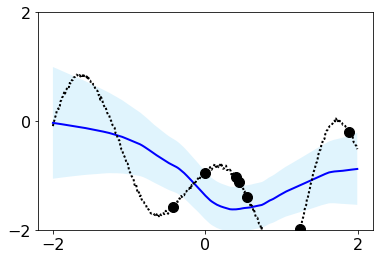

Iteration: 32100, loss: 0.903380811214447
Iteration: 32200, loss: 0.5434737801551819
Iteration: 32300, loss: 0.7895165681838989
Iteration: 32400, loss: 1.2075039148330688
Iteration: 32500, loss: 0.746188223361969
Iteration: 32600, loss: 0.2997639775276184
Iteration: 32700, loss: 1.180198073387146
Iteration: 32800, loss: 0.4747905135154724
Iteration: 32900, loss: 0.3717570900917053
Iteration: 33000, loss: 0.7745410203933716
(400, 1)
(1, 400, 1)
Iteration: 33000, loss: 0.6171587705612183


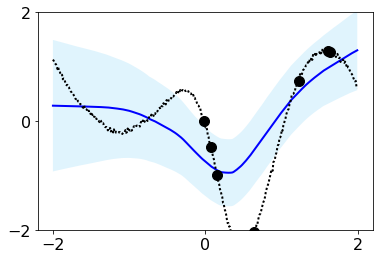

Iteration: 33100, loss: 0.921341598033905
Iteration: 33200, loss: 2.4691905975341797
Iteration: 33300, loss: 1.4802043437957764
Iteration: 33400, loss: 0.94594806432724
Iteration: 33500, loss: 0.534395694732666
Iteration: 33600, loss: 0.8362486958503723
Iteration: 33700, loss: 1.1798828840255737
Iteration: 33800, loss: 0.7232562303543091
Iteration: 33900, loss: 0.8374362587928772
Iteration: 34000, loss: 0.6887415647506714
(400, 1)
(1, 400, 1)
Iteration: 34000, loss: 0.9921414256095886


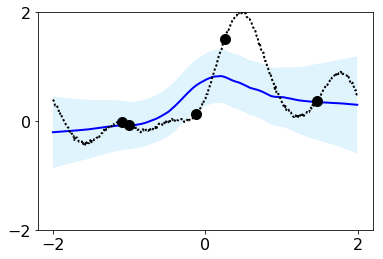

Iteration: 34100, loss: 1.0562134981155396
Iteration: 34200, loss: 0.5757896304130554
Iteration: 34300, loss: 0.4698924720287323
Iteration: 34400, loss: 1.2394942045211792
Iteration: 34500, loss: 1.278208613395691
Iteration: 34600, loss: 0.7741111516952515
Iteration: 34700, loss: 1.3608981370925903
Iteration: 34800, loss: 0.5467069745063782
Iteration: 34900, loss: 0.6501514315605164
Iteration: 35000, loss: 1.0982917547225952
(400, 1)
(1, 400, 1)
Iteration: 35000, loss: 5.135476112365723


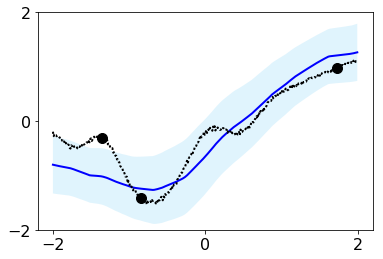

Iteration: 35100, loss: 0.49137789011001587
Iteration: 35200, loss: 0.3579806685447693
Iteration: 35300, loss: 0.5748767852783203
Iteration: 35400, loss: 0.6760587096214294
Iteration: 35500, loss: 0.7249563932418823
Iteration: 35600, loss: 1.019423007965088
Iteration: 35700, loss: 0.8336753845214844
Iteration: 35800, loss: 1.1567929983139038
Iteration: 35900, loss: 1.14583420753479
Iteration: 36000, loss: 1.2289458513259888
(400, 1)
(1, 400, 1)
Iteration: 36000, loss: 0.6440859436988831


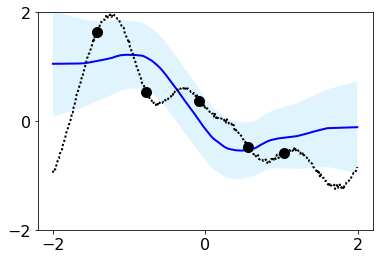

Iteration: 36100, loss: 0.62503582239151
Iteration: 36200, loss: 0.37854066491127014
Iteration: 36300, loss: 0.32457754015922546
Iteration: 36400, loss: 0.6370275616645813
Iteration: 36500, loss: 1.144454002380371
Iteration: 36600, loss: 0.9787840247154236
Iteration: 36700, loss: 0.4832395017147064
Iteration: 36800, loss: 0.9158931970596313
Iteration: 36900, loss: 0.6015561819076538
Iteration: 37000, loss: 0.7681542038917542
(400, 1)
(1, 400, 1)
Iteration: 37000, loss: 1.3753373622894287


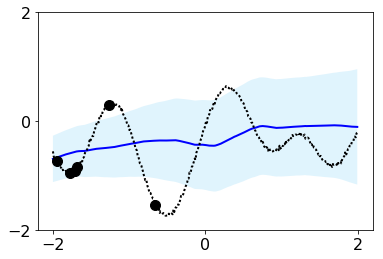

Iteration: 37100, loss: 0.5324596166610718
Iteration: 37200, loss: 1.3661912679672241
Iteration: 37300, loss: 1.5970489978790283
Iteration: 37400, loss: 0.908128559589386
Iteration: 37500, loss: 0.5844987630844116
Iteration: 37600, loss: 1.400463342666626
Iteration: 37700, loss: 0.5328961610794067
Iteration: 37800, loss: 0.6671653985977173
Iteration: 37900, loss: 0.6614977717399597
Iteration: 38000, loss: 0.950020968914032
(400, 1)
(1, 400, 1)
Iteration: 38000, loss: 1.079362392425537


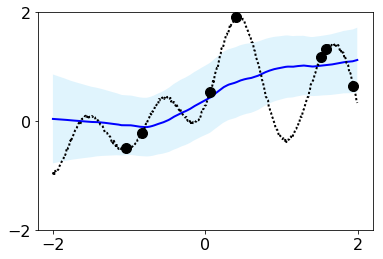

Iteration: 38100, loss: 0.6821718215942383
Iteration: 38200, loss: 0.4377829432487488
Iteration: 38300, loss: 1.4049674272537231
Iteration: 38400, loss: 0.6556195020675659
Iteration: 38500, loss: 0.6745724678039551
Iteration: 38600, loss: 0.8475831151008606
Iteration: 38700, loss: 0.6256138682365417
Iteration: 38800, loss: 0.9749583601951599
Iteration: 38900, loss: 2.343003034591675
Iteration: 39000, loss: 0.624302327632904
(400, 1)
(1, 400, 1)
Iteration: 39000, loss: 1.548128366470337


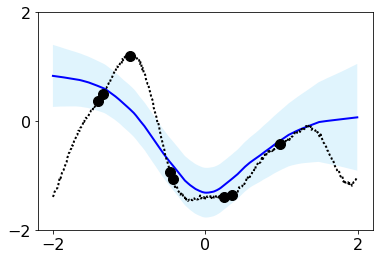

Iteration: 39100, loss: 0.9930644631385803
Iteration: 39200, loss: 0.7808386087417603
Iteration: 39300, loss: 0.731513261795044
Iteration: 39400, loss: 0.47172707319259644
Iteration: 39500, loss: 0.9783766865730286
Iteration: 39600, loss: 1.258122444152832
Iteration: 39700, loss: 0.26010650396347046
Iteration: 39800, loss: 0.35872596502304077
Iteration: 39900, loss: 1.1872884035110474
Iteration: 40000, loss: 1.2280124425888062
(400, 1)
(1, 400, 1)
Iteration: 40000, loss: 0.7855814695358276


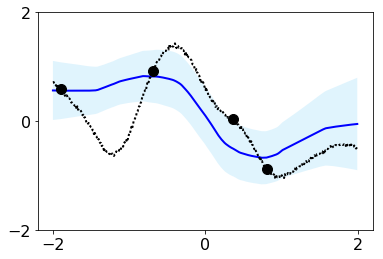

Iteration: 40100, loss: 0.37660375237464905
Iteration: 40200, loss: 1.4134167432785034
Iteration: 40300, loss: 0.7653573751449585
Iteration: 40400, loss: 0.8850165605545044
Iteration: 40500, loss: 1.517528772354126
Iteration: 40600, loss: 0.2669702172279358
Iteration: 40700, loss: 0.9829466938972473
Iteration: 40800, loss: 0.41971370577812195
Iteration: 40900, loss: 0.46547964215278625
Iteration: 41000, loss: 0.84578937292099
(400, 1)
(1, 400, 1)
Iteration: 41000, loss: 0.6373055577278137


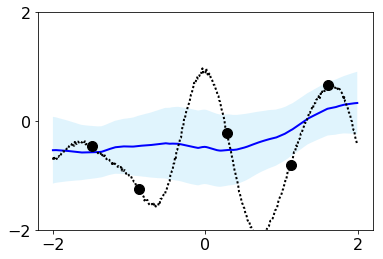

Iteration: 41100, loss: 1.2616994380950928
Iteration: 41200, loss: 0.5244815349578857
Iteration: 41300, loss: 1.1819719076156616
Iteration: 41400, loss: 1.1838667392730713
Iteration: 41500, loss: 0.6361532211303711
Iteration: 41600, loss: 0.8007897138595581
Iteration: 41700, loss: 1.282934546470642
Iteration: 41800, loss: 0.5657559633255005
Iteration: 41900, loss: 0.7442640662193298
Iteration: 42000, loss: 1.0559889078140259
(400, 1)
(1, 400, 1)
Iteration: 42000, loss: 1.0052783489227295


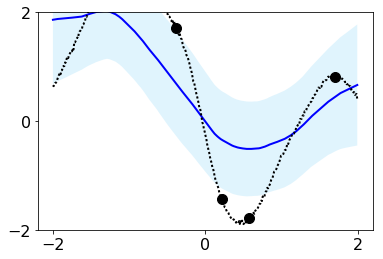

Iteration: 42100, loss: 1.2027246952056885
Iteration: 42200, loss: 1.2809369564056396
Iteration: 42300, loss: 0.9472364187240601
Iteration: 42400, loss: 1.2724496126174927
Iteration: 42500, loss: 0.7066888213157654
Iteration: 42600, loss: 0.6150493621826172
Iteration: 42700, loss: 0.6749176979064941
Iteration: 42800, loss: 0.6279469132423401
Iteration: 42900, loss: 0.9183181524276733
Iteration: 43000, loss: 0.8385929465293884
(400, 1)
(1, 400, 1)
Iteration: 43000, loss: 0.5304427742958069


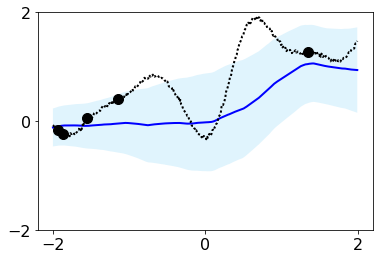

Iteration: 43100, loss: 1.0889137983322144
Iteration: 43200, loss: 1.018696904182434
Iteration: 43300, loss: 0.7587027549743652
Iteration: 43400, loss: 0.9929528832435608
Iteration: 43500, loss: 0.7889760732650757
Iteration: 43600, loss: 0.8081513047218323
Iteration: 43700, loss: 0.36609774827957153
Iteration: 43800, loss: 0.8144292831420898
Iteration: 43900, loss: 0.7947778701782227
Iteration: 44000, loss: 0.3586218059062958
(400, 1)
(1, 400, 1)
Iteration: 44000, loss: 0.7791377902030945


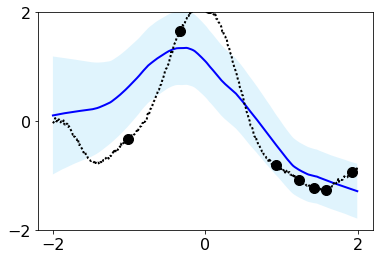

Iteration: 44100, loss: 0.5589657425880432
Iteration: 44200, loss: 0.694101095199585
Iteration: 44300, loss: 0.47487756609916687
Iteration: 44400, loss: 0.6277961730957031
Iteration: 44500, loss: 1.1193383932113647
Iteration: 44600, loss: 1.1134883165359497
Iteration: 44700, loss: 1.3981786966323853
Iteration: 44800, loss: 0.4297519624233246
Iteration: 44900, loss: 0.4558904469013214
Iteration: 45000, loss: 0.8376886248588562
(400, 1)
(1, 400, 1)
Iteration: 45000, loss: 0.47671958804130554


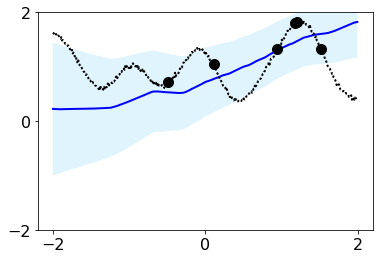

Iteration: 45100, loss: 0.6690002083778381
Iteration: 45200, loss: 1.101943850517273
Iteration: 45300, loss: 0.9655120372772217
Iteration: 45400, loss: 0.2896241247653961
Iteration: 45500, loss: 0.7679939866065979
Iteration: 45600, loss: 0.7289762496948242
Iteration: 45700, loss: 0.5705557465553284
Iteration: 45800, loss: 0.8697330355644226
Iteration: 45900, loss: 0.3523866832256317
Iteration: 46000, loss: 0.6872808337211609
(400, 1)
(1, 400, 1)
Iteration: 46000, loss: 0.8383853435516357


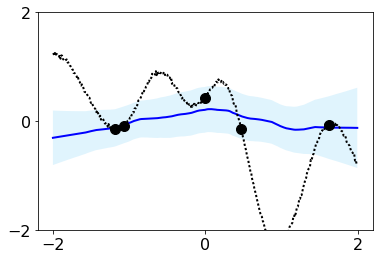

Iteration: 46100, loss: 0.9638208150863647
Iteration: 46200, loss: 1.3836991786956787
Iteration: 46300, loss: 0.643488347530365
Iteration: 46400, loss: 0.708942711353302
Iteration: 46500, loss: 0.6301963925361633
Iteration: 46600, loss: 0.30013203620910645
Iteration: 46700, loss: 0.6557031273841858
Iteration: 46800, loss: 1.0264991521835327
Iteration: 46900, loss: 0.49072712659835815
Iteration: 47000, loss: 0.6357266306877136
(400, 1)
(1, 400, 1)
Iteration: 47000, loss: 0.6276312470436096


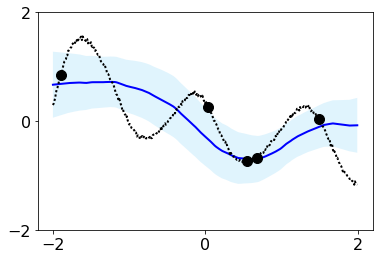

Iteration: 47100, loss: 0.6801235675811768
Iteration: 47200, loss: 0.9330565333366394
Iteration: 47300, loss: 0.27018314599990845
Iteration: 47400, loss: 0.7134683132171631
Iteration: 47500, loss: 1.0734745264053345
Iteration: 47600, loss: 0.5586056709289551
Iteration: 47700, loss: 1.1108478307724
Iteration: 47800, loss: 0.7558326721191406
Iteration: 47900, loss: 0.9303215742111206
Iteration: 48000, loss: 0.4493509829044342
(400, 1)
(1, 400, 1)
Iteration: 48000, loss: 0.7504574656486511


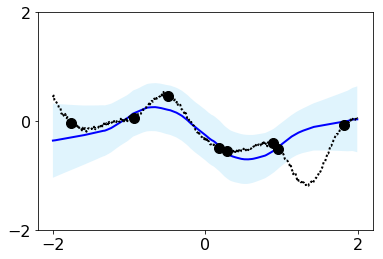

Iteration: 48100, loss: 1.4765353202819824
Iteration: 48200, loss: 0.31600481271743774
Iteration: 48300, loss: 0.43971359729766846
Iteration: 48400, loss: 0.9576555490493774
Iteration: 48500, loss: 0.6753256320953369
Iteration: 48600, loss: 0.6741700768470764
Iteration: 48700, loss: 0.8172152042388916
Iteration: 48800, loss: 0.452614426612854
Iteration: 48900, loss: 1.7332332134246826
Iteration: 49000, loss: 0.6053957939147949
(400, 1)
(1, 400, 1)
Iteration: 49000, loss: 0.46020546555519104


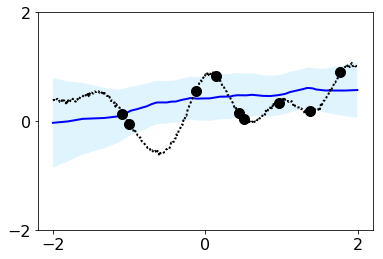

Iteration: 49100, loss: 0.6492235660552979
Iteration: 49200, loss: 1.0040217638015747
Iteration: 49300, loss: 0.4187779128551483
Iteration: 49400, loss: 0.6438288688659668
Iteration: 49500, loss: 0.5503712892532349
Iteration: 49600, loss: 0.1290380358695984
Iteration: 49700, loss: 0.16775605082511902
Iteration: 49800, loss: 0.799789309501648
Iteration: 49900, loss: 0.49739938974380493
Iteration: 50000, loss: 0.7355042695999146
(400, 1)
(1, 400, 1)
Iteration: 50000, loss: 0.9549707174301147


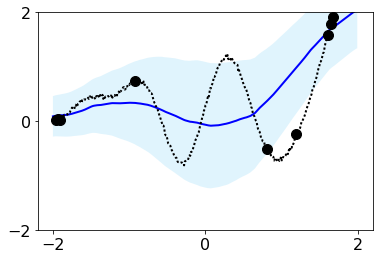

Iteration: 50100, loss: 0.7149004340171814
Iteration: 50200, loss: 1.1255030632019043
Iteration: 50300, loss: 1.0155746936798096
Iteration: 50400, loss: 1.3544120788574219
Iteration: 50500, loss: 0.8115212321281433
Iteration: 50600, loss: 0.4136722981929779
Iteration: 50700, loss: 0.7970746755599976
Iteration: 50800, loss: 1.3995710611343384
Iteration: 50900, loss: 1.1831109523773193
Iteration: 51000, loss: 0.5715216398239136
(400, 1)
(1, 400, 1)
Iteration: 51000, loss: 0.8956273198127747


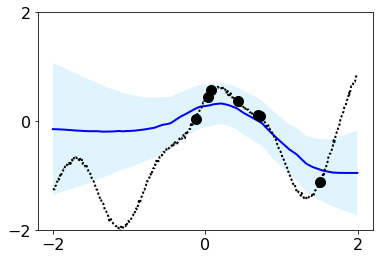

Iteration: 51100, loss: 0.4240916073322296
Iteration: 51200, loss: 0.6802721619606018
Iteration: 51300, loss: 0.8672495484352112
Iteration: 51400, loss: 0.5784900188446045
Iteration: 51500, loss: 0.7316367030143738
Iteration: 51600, loss: 1.1061393022537231
Iteration: 51700, loss: 0.7142751812934875
Iteration: 51800, loss: 0.6342402696609497
Iteration: 51900, loss: 0.5284861326217651
Iteration: 52000, loss: 0.7890855073928833
(400, 1)
(1, 400, 1)
Iteration: 52000, loss: 0.6795486807823181


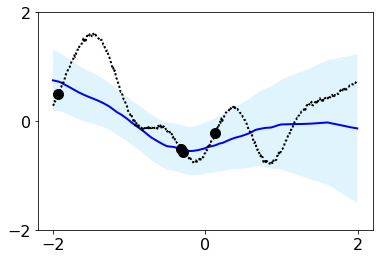

Iteration: 52100, loss: 0.788406491279602
Iteration: 52200, loss: 0.5299943685531616
Iteration: 52300, loss: 0.6982652544975281
Iteration: 52400, loss: 1.5184773206710815
Iteration: 52500, loss: 0.8552216291427612
Iteration: 52600, loss: 0.5330116748809814
Iteration: 52700, loss: 0.8990908265113831
Iteration: 52800, loss: 0.5323534607887268
Iteration: 52900, loss: 0.34875720739364624
Iteration: 53000, loss: 0.6470691561698914
(400, 1)
(1, 400, 1)
Iteration: 53000, loss: 0.7227461934089661


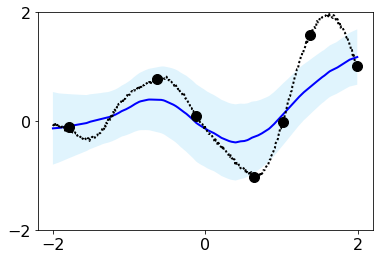

Iteration: 53100, loss: 0.7642057538032532
Iteration: 53200, loss: 1.0627198219299316
Iteration: 53300, loss: 1.107607126235962
Iteration: 53400, loss: 0.6767982244491577
Iteration: 53500, loss: 1.4998903274536133
Iteration: 53600, loss: 1.1839427947998047
Iteration: 53700, loss: 0.2184530645608902
Iteration: 53800, loss: 1.0587941408157349
Iteration: 53900, loss: 0.5653245449066162
Iteration: 54000, loss: 1.0549440383911133
(400, 1)
(1, 400, 1)
Iteration: 54000, loss: 0.36411869525909424


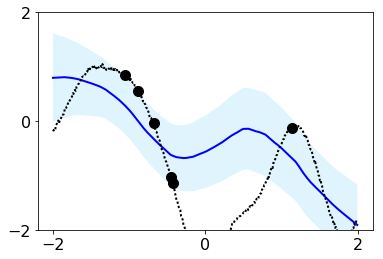

Iteration: 54100, loss: 0.7558562755584717
Iteration: 54200, loss: 1.1801133155822754
Iteration: 54300, loss: 0.5916869044303894
Iteration: 54400, loss: 1.1342041492462158
Iteration: 54500, loss: 0.6285868287086487
Iteration: 54600, loss: 0.6128128170967102
Iteration: 54700, loss: 0.116353839635849
Iteration: 54800, loss: 0.6529913544654846
Iteration: 54900, loss: 0.5376402139663696
Iteration: 55000, loss: 0.3444671034812927
(400, 1)
(1, 400, 1)
Iteration: 55000, loss: 1.2820461988449097


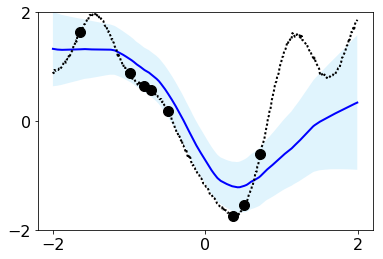

Iteration: 55100, loss: 0.8743420839309692
Iteration: 55200, loss: 0.6845000386238098
Iteration: 55300, loss: 0.6099292635917664
Iteration: 55400, loss: 0.6217530369758606
Iteration: 55500, loss: 0.9752882719039917
Iteration: 55600, loss: 0.1552092432975769
Iteration: 55700, loss: 0.3270820677280426
Iteration: 55800, loss: 0.7613664269447327
Iteration: 55900, loss: 0.8662710785865784
Iteration: 56000, loss: 1.0563712120056152
(400, 1)
(1, 400, 1)
Iteration: 56000, loss: 1.193886637687683


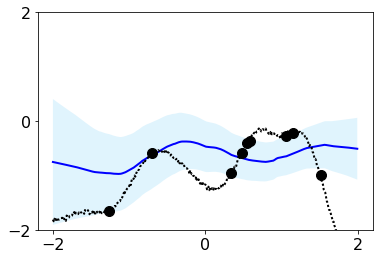

Iteration: 56100, loss: 0.49411478638648987
Iteration: 56200, loss: 0.4392109811306
Iteration: 56300, loss: 0.929570734500885
Iteration: 56400, loss: 0.8765566349029541
Iteration: 56500, loss: 1.211114525794983
Iteration: 56600, loss: 0.3988586664199829
Iteration: 56700, loss: 0.6015082597732544
Iteration: 56800, loss: 0.29713550209999084
Iteration: 56900, loss: 0.9864108562469482
Iteration: 57000, loss: 0.5813215374946594
(400, 1)
(1, 400, 1)
Iteration: 57000, loss: 0.5885646939277649


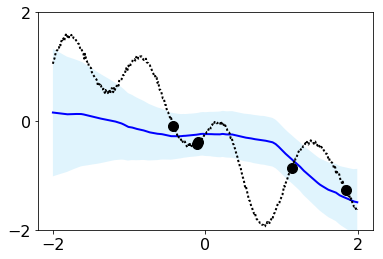

Iteration: 57100, loss: 1.0377620458602905
Iteration: 57200, loss: 0.6494136452674866
Iteration: 57300, loss: 1.0454145669937134
Iteration: 57400, loss: 0.400676965713501
Iteration: 57500, loss: 0.6004352569580078
Iteration: 57600, loss: 2.224771022796631
Iteration: 57700, loss: 0.698682427406311
Iteration: 57800, loss: 0.569994330406189
Iteration: 57900, loss: 1.2420722246170044
Iteration: 58000, loss: 0.9788026213645935
(400, 1)
(1, 400, 1)
Iteration: 58000, loss: 0.5337070822715759


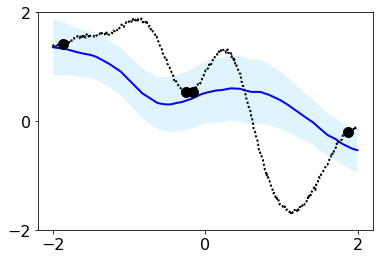

Iteration: 58100, loss: 0.46426981687545776


KeyboardInterrupt: 

In [6]:
TRAINING_ITERATIONS = int(2e5)
MAX_CONTEXT_POINTS = 10

tf.reset_default_graph()

dataset_train = GPCurvesReader(batch_size=1, max_num_context=MAX_CONTEXT_POINTS)
data_train = dataset_train.generate_curves()

dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True)
data_test = dataset_test.generate_curves()

# encoder_output_sizes = [128, 128, 128, 128]
# decoder_output_sizes = [128, 128, 2]

# model = DeterministicModel(encoder_output_sizes, decoder_output_sizes)


log_prob, _, _ = model(data_train.query, data_train.num_total_points, data_train.target_y)
# log_prob, _, _ = model(data_train.query, data_train.num_total_points, data_train.num_context_points, data_train.target_y)
loss = -tf.reduce_mean(log_prob)

# Get the predicted mean and variance at the target points for the testing set
# _, mu, sigma = model(data_test.query, data_test.num_total_points, data_test.num_context_points)
_, mu, sigma = model(data_test.query, data_test.num_total_points)


optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)
init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)

    for it in range(TRAINING_ITERATIONS):
        sess.run([train_step])
        
        if it % 100 == 0:
            loss_value, pred_y, var, target_y, whole_query = sess.run(
                [loss, mu, sigma, data_test.target_y, data_test.query])

            (context_x, context_y), target_x = whole_query
            print('Iteration: {}, loss: {}'.format(it, loss_value))

        if it%1000 == 0:
            loss_value, pred_y, var, target_y, whole_query = sess.run(
                [loss, mu, sigma, data_test.target_y, data_test.query])
            (context_x, context_y), target_x = whole_query
            print(pred_y.shape)
            print(target_x.shape)
            print('Iteration: {}, loss: {}'.format(it, loss_value))

            plot_functions(target_x, target_y, context_x, context_y, pred_y, var)

In [ ]:
x_dim = 1
y_dim = 1
encoder_input = tf.placeholder(dtype = tf.float32, shape=[None, x_dim+y_dim], name='encoder_input')
encoder_layer1 = tf.contrib.layers.fully_connected(encoder_input, 128)#,normalizer_fn=tf.contrib.layers.batch_norm)
encoder_layer2 = tf.contrib.layers.fully_connected(encoder_layer1, 128)#,normalizer_fn=tf.contrib.layers.batch_norm)
encoder_layer3 = tf.contrib.layers.fully_connected(encoder_layer2, 128)#,normalizer_fn=tf.contrib.layers.batch_norm)
encoder_layer4 = tf.contrib.layers.fully_connected(encoder_layer3, 128,)#normalizer_fn=tf.contrib.layers.batch_norm)
r = tf.reduce_sum(encoder_layer4, axis= 0,keep_dims=True)

decoder_input = tf.placeholder(dtype=tf.float32, shape=[None, x_dim], name='decoder_input')
decoder_output = tf.placeholder(dtype=tf.float32, shape = [None, y_dim], name='decoder_output')
decoder_input_rows = tf.shape(decoder_input)[0]
r_tiled = tf.tile(r, [decoder_input_rows, 1])
decoder_input_con = tf.concat([decoder_input, r_tiled], 1)
decoder_layer1 = tf.contrib.layers.fully_connected(decoder_input_con, 128)#,normalizer_fn=tf.contrib.layers.batch_norm)
decoder_layer2 = tf.contrib.layers.fully_connected(decoder_layer1, 128)#,normalizer_fn=tf.contrib.layers.batch_norm)
# decoder_layer3 = tf.contrib.layers.fully_connected(decoder_layer2, 128)#,normalizer_fn=tf.contrib.layers.batch_norm)
decoder_mean = tf.contrib.layers.fully_connected(decoder_layer2, 1, activation_fn=None)#,normalizer_fn=tf.contrib.layers.batch_norm)
decoder_var = tf.contrib.layers.fully_connected(decoder_layer2, 1, activation_fn=None)#,normalizer_fn=tf.contrib.layers.batch_norm)
decoder_var = 0.1 + 0.9*tf.nn.softplus(decoder_var)
dist = tf.contrib.distributions.MultivariateNormalDiag(mu=decoder_mean, diag_stdev=decoder_var)

# square_difference = tf.squared_difference(decoder_mean, decoder_output)
# losses = tf.div(square_difference, decoder_var+1e-7) + tf.log(decoder_var+1e-7)
losses = -dist.log_prob(decoder_output)
# losses = tf.div(square_difference, decoder_var) + tf.log(decoder_var)
loss = tf.reduce_mean(losses)

In [18]:
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gp = GaussianProcessRegressor(kernel=kernel)
def generate_data():
    random_state = np.random.randint(low = 0, high=100)
    size = np.random.randint(low=4, high=20)
    X = np.random.uniform(-2, 2, size = size).reshape(-1, 1)
    Y = gp.sample_y(X, random_state=random_state)
    encoder_input_all = np.concatenate((X.reshape(-1, 1), Y), axis= 1)
    encoder_input_index = np.random.choice(range(X.shape[0]), size=np.random.randint(low = 1, high=X.shape[0]/2), replace=False)
    encoder_input_select= encoder_input_all[encoder_input_index]
    return encoder_input_select, X, Y

def generate_test_data():
#     rng = np.random.RandomState(4)
    size=np.random.randint(low = 1, high=10)
    X = np.random.uniform(-2, 2, size)[:, np.newaxis]
    Y = gp.sample_y(X)#, random_state=random_state)
    encoder_input_all = np.concatenate((X.reshape(-1, 1), Y), axis= 1)
#     encoder_input_index = np.random.choice(range(X.shape[0]), size=np.random.randint(low = 1, high=10), replace=False)
    X_ = np.linspace(-2,2,100)
    return encoder_input_all, X_, X, Y.reshape(-1)
#     X = rng.uniform(-2, 2, 10)[:, np.newaxis]
#     Y = gp.sample_y(X, random_state=random_state)
#     y = np.sin((X[:, 0] - 2.5) ** 2)
    
#     X_ = np.linspace(-2,2,100)
#     encoder_input_select = np.concatenate((X, y.reshape(-1,1)), axis = 1)
#     return encoder_input_select, X_, X, y

2.1493702


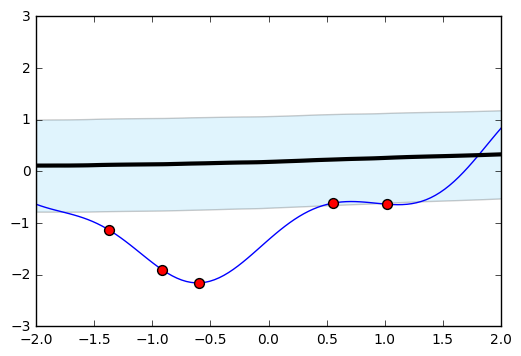

1.2158078
1.0293987
1.187217
0.90091336
0.71351093
0.6187655
0.85748506
1.3804588
2.188437
0.8110027


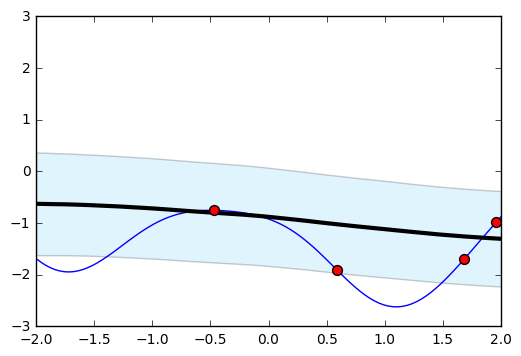

0.5759467
1.2827544
0.7520344
1.6918224
0.4912886
1.3479043
1.0752143
0.80158615
0.65799445
0.6698275


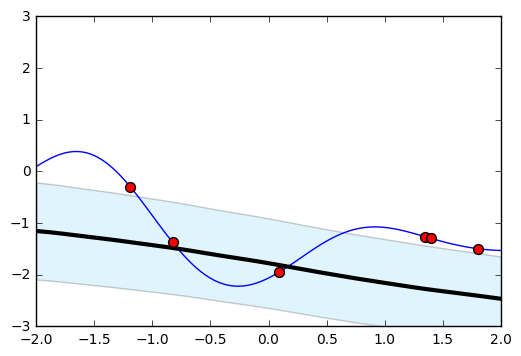

1.2550627
1.0102692
1.2633595
0.9536012
1.4716003
1.1865431
1.2198788
0.3023467
0.5729333
0.47446677


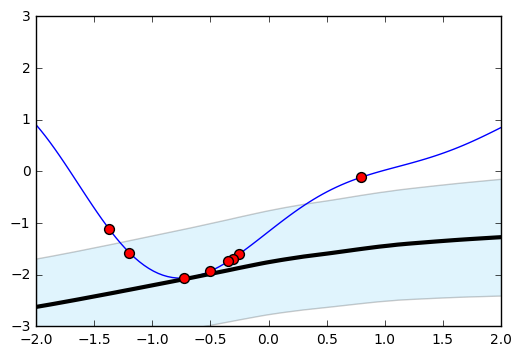

0.6082013
0.23423283
1.7579478
1.1361349
0.7649906
1.6186329
1.2434881
3.7561297
0.22083682
1.5569654


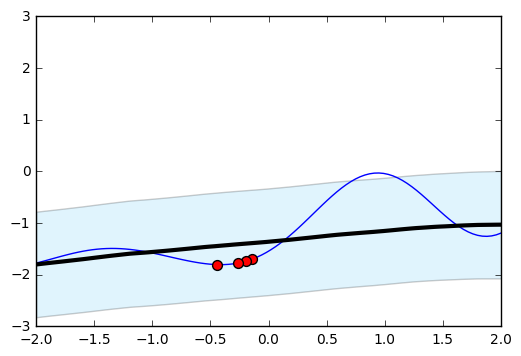

1.2047696
0.9542536
0.90102905
1.3464956
0.38491446
0.66899395
0.54193556
1.3873256
0.71682507
1.2351923


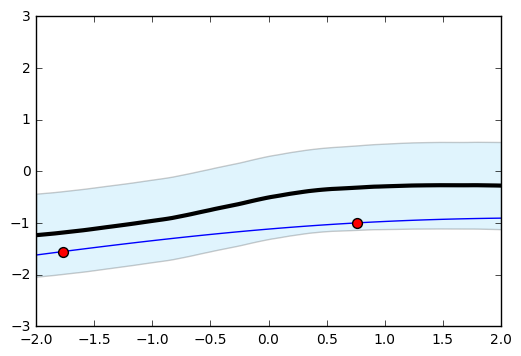

1.0071951
1.3634593
1.3455075
0.9381833
0.7194009
0.84111476
1.5150144
1.3155282
0.31085116
0.34151974


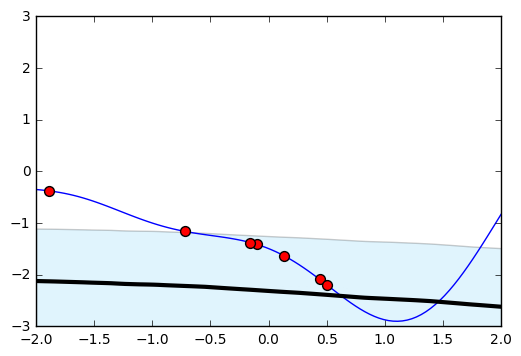

1.3613975
0.74533546
0.5409579
0.7851871
0.9085869
0.54169035
0.9142844
0.7675725
0.4247561
0.94811267


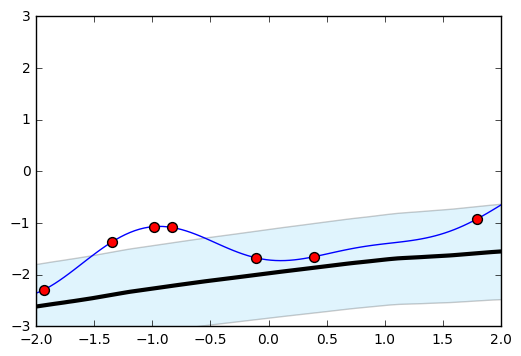

1.3383675
0.85949075
0.11951343
0.7455325
0.05899478
1.4201531
0.80191207
1.1234832
1.2115184
0.71802616


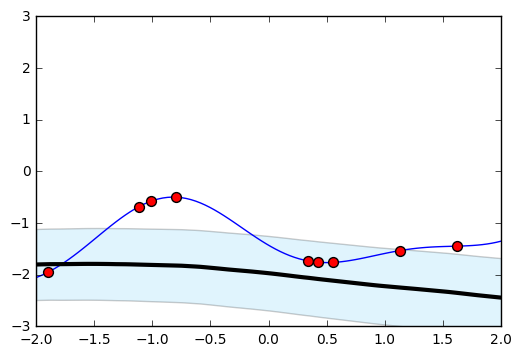

1.379752
1.0533394
0.7265847
1.0211344
0.7009863
1.4358723
1.1107392
1.042388
0.39712226
0.40293252


/Users/fanfan/anaconda/envs/dlnd-tf-lab/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-4.04473394e-05]), 'funcalls': 69, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


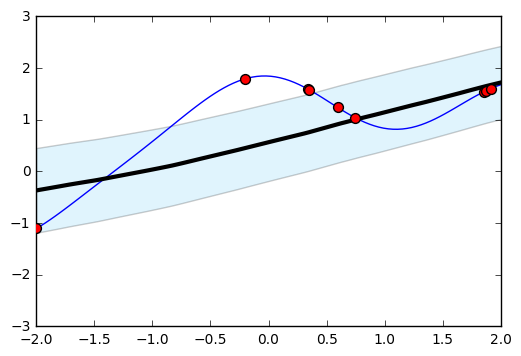

0.60116947
0.1936153
0.7411924
1.4554151
1.1407748
0.6326181
0.7014961
0.31891662
0.2896692
0.88833123


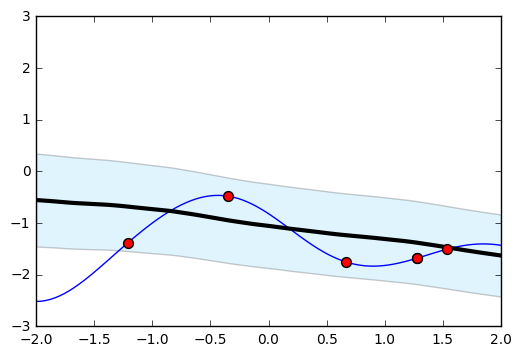

0.7733432
0.7414663
0.5937536
0.93076164
0.9078126
1.0322604
-0.02844584
-0.13608111
0.9820572
1.2514278


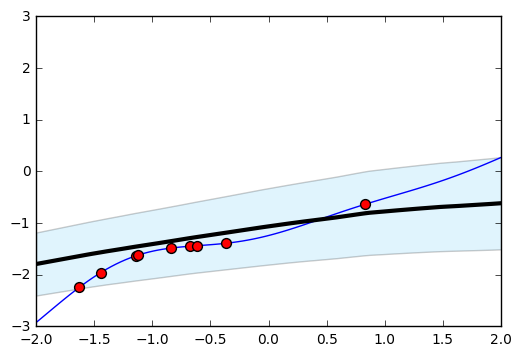

0.89907455
1.0751585
0.811907
0.11997289
0.22484551
0.6046197
1.2271228
0.6025687
0.63027585
0.62871516


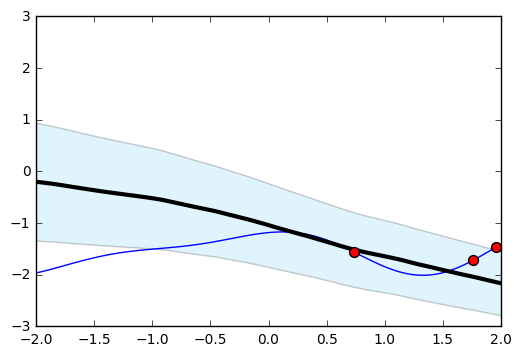

0.48965502
1.7353446
1.1638644
0.841835
0.12946235
0.6791703
0.9114977
0.420791
0.43239963
0.9631149


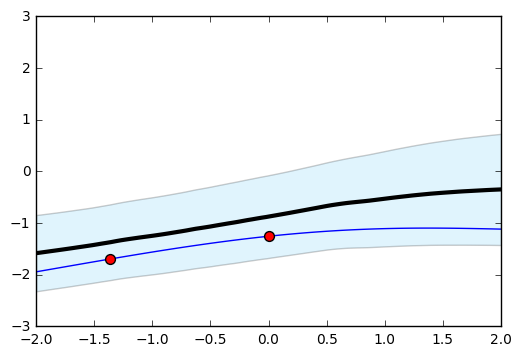

0.35767603
0.20850042
0.34398493
1.0698225
0.16685444
0.9926044
1.1019381
0.9053939
0.118809216
1.1427894


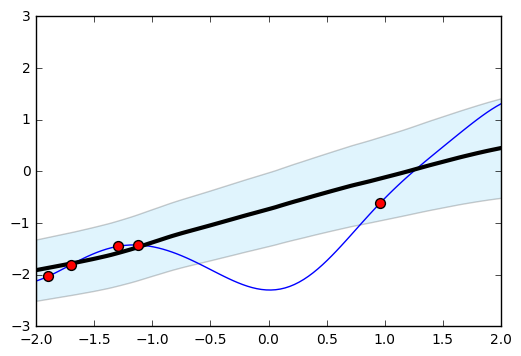

0.49437046
0.62153083
1.0172188
0.6233635
0.19761235
1.3667781
0.27346388
0.22371222
1.0964458
0.3518141


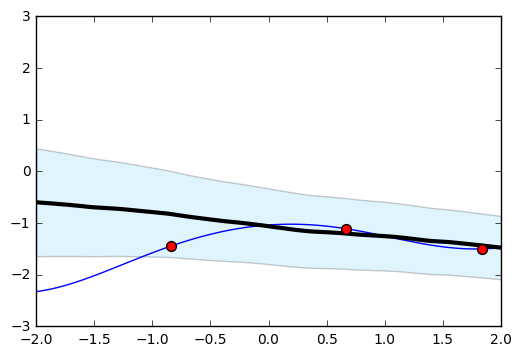

1.0761572
0.7921255
0.61273426
0.4716293
0.69613796
1.4780877
0.7411723
0.90361726
0.24343841
0.112407796


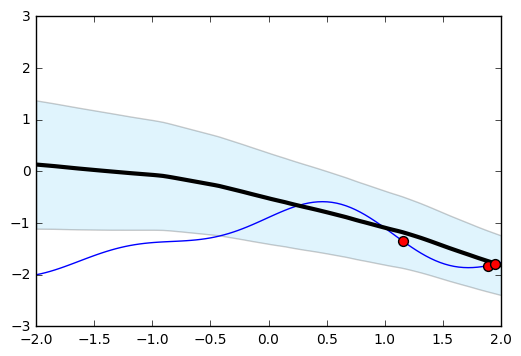

0.5992355
1.1314316
0.63482493
0.26222482
0.8695415
0.43439132
0.7785069
0.6428003
0.25254664
0.16277358


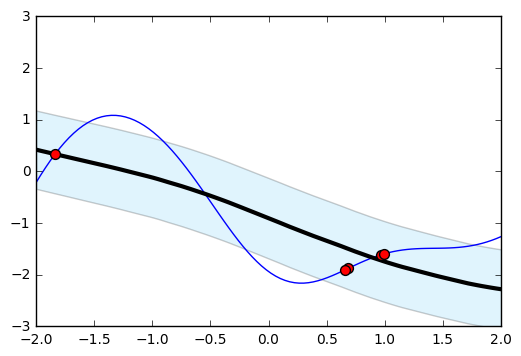

1.3580116
0.59518415
3.5023456
0.33482385
0.39543563
0.51741487
1.5430206
0.65411663
0.4416858
1.3159919


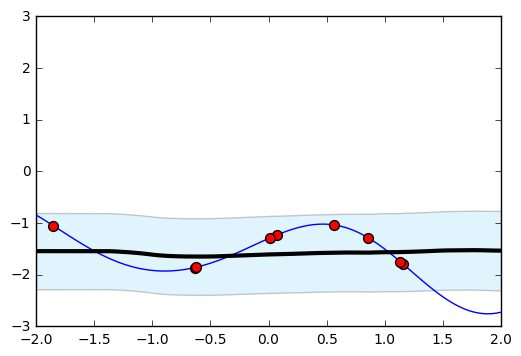

0.8523602
0.81741005
0.028907217
0.82894325
0.63716364
0.34161282
0.9519742
1.8004055
2.0338943
0.7881605


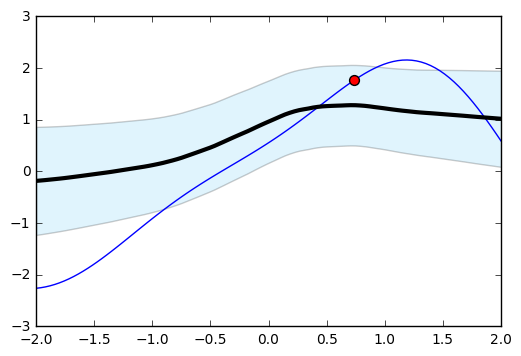

0.5659594
0.0024309873
2.4624102
1.3323789
0.73822004
0.31629023
0.46833804
1.226993
0.36541107
0.030451762


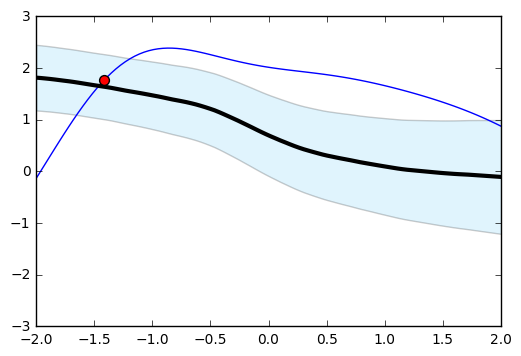

1.0734793
0.9992528
0.8787893
0.029923312
0.8678065
0.8943386
0.04280998
0.8316494
0.32085824
0.32473865


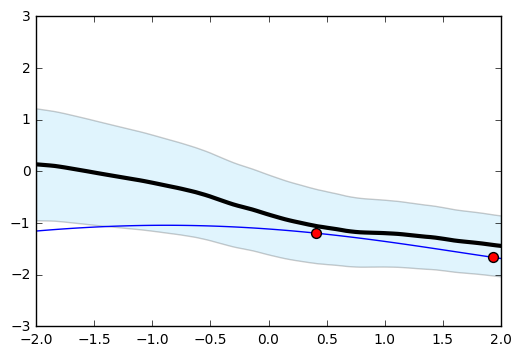

1.2568161
1.2247765
0.30029792
1.177737
0.4385673
1.271879
0.5925008
1.1320649
0.26776007
0.7288607


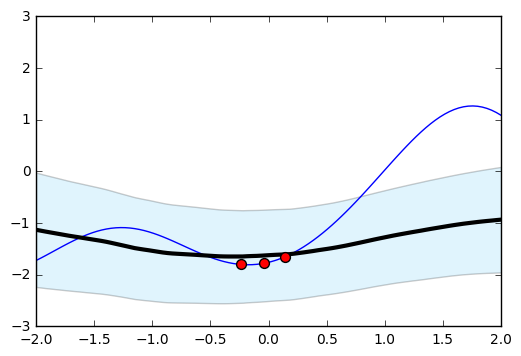

0.41234222
1.0064031
1.2074096
0.10005933
0.6037253
0.8938719
0.8246929
0.45845693
0.38564688
0.75392795


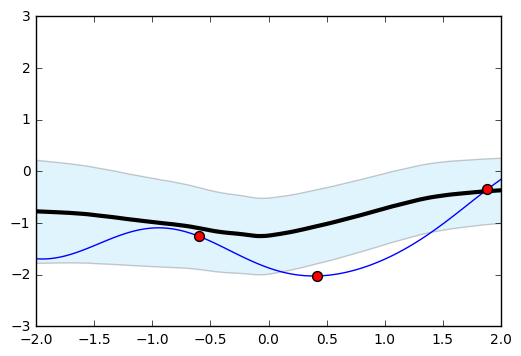

2.0239005
0.4305025
0.5175674
0.55366266
0.6145964
0.20037347
3.1869483
0.6001914
0.11202208
1.1484153


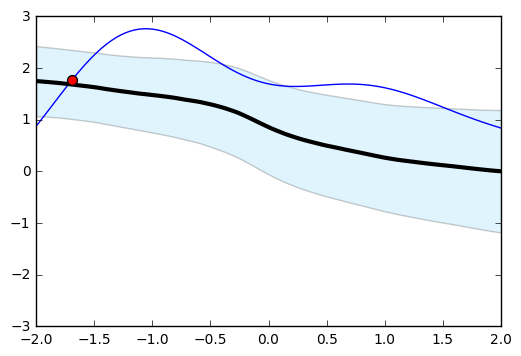

0.5152564
1.2193154
0.7483373
-0.065695494
0.7439884
0.57230675
0.109281994
0.3498554
0.6280288
0.21468359


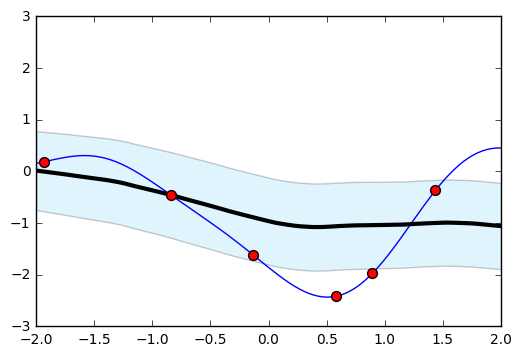

-0.011971075
1.1107846
0.26431552
0.7551873
1.173191
0.9069569
0.86505145
0.5928057
1.3668933
-0.060081534


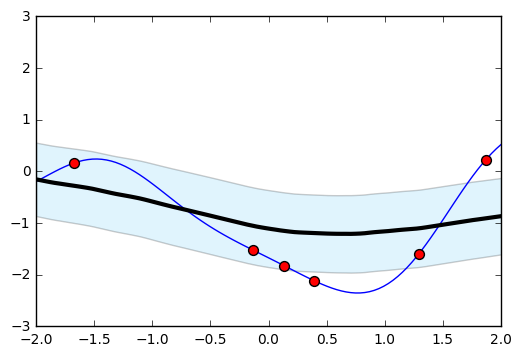

0.20363815
0.39959893
0.21221614
1.7105086
0.83224297
1.7028656
0.5647584
0.90515107
0.017577281
0.1876043


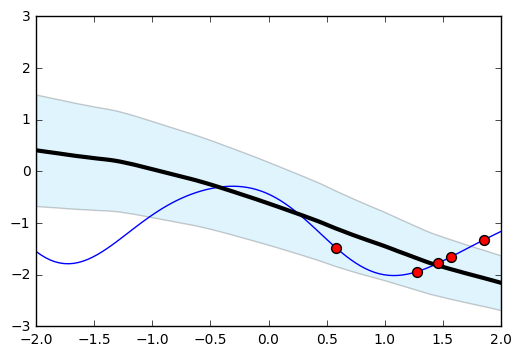

0.6724286
1.8684198
0.92009175
0.4199825
0.6717389
0.13114682
1.2027949
0.5804923
0.08978832
0.9170558


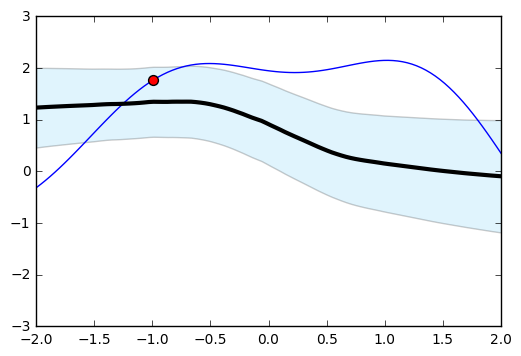

0.21953425
0.36245352
0.1625008
0.48823914
0.10090935
0.6025855
0.45949206
1.0120091
0.636255
0.9385572


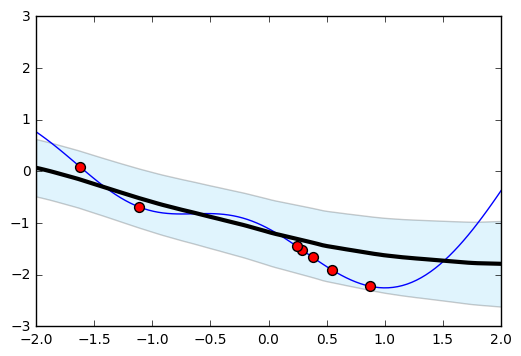

1.1019305
0.08637427
1.5010884
0.29554126
-0.015797492
1.6669253
0.37689587
1.2809204
0.71504545
0.34032047


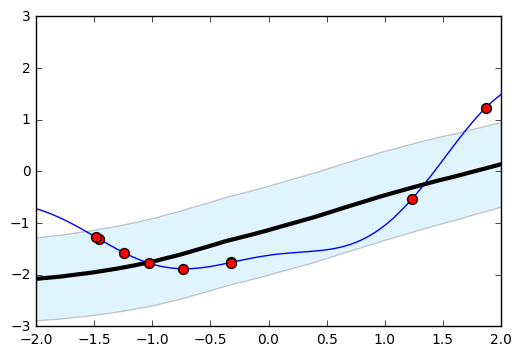

1.0519698
1.3223925
0.754639
0.37221733
0.700071
0.6869963
-0.017926103
0.95676225
1.9766866
0.80970126


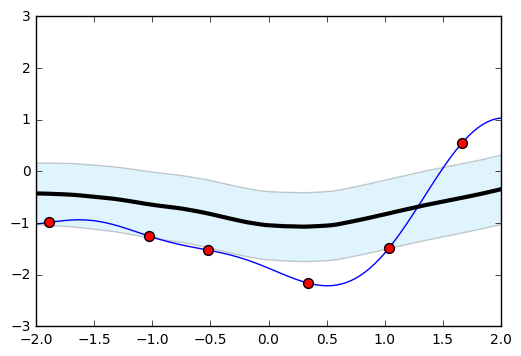

0.23823346
1.0226635
0.8218058
0.68872243
0.99085164
0.4291896
1.8883661
0.35365555
0.8804298
1.0790337


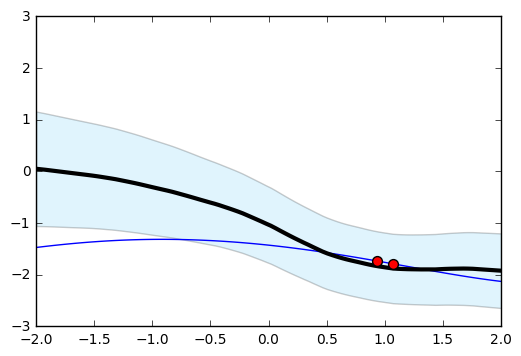

0.7198416
0.79068696
0.25834164
0.13103282
0.7743214
0.44265124
0.2828937
0.28973186
0.29892588
0.3211983


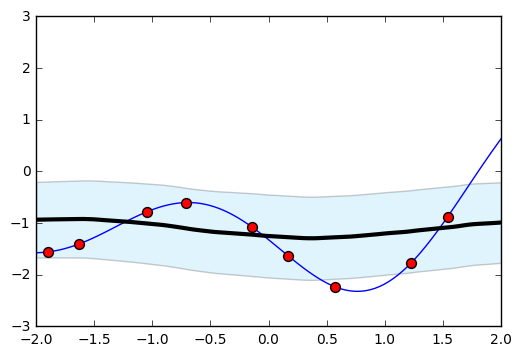

1.2262453
2.5228355
0.9869238
0.55023783
0.91667795
0.24876894
0.88871145
0.77711034
0.41762826
1.1615453


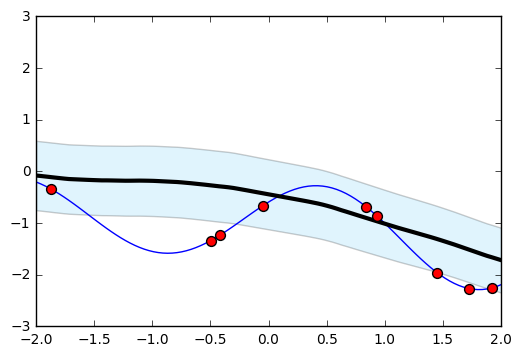

0.5783758
0.16487336
0.2773472
1.2557545
2.1710942
0.7377266
0.29439896
0.59375286
1.4577732
0.6950885


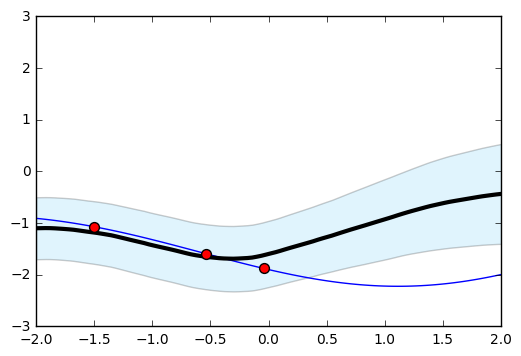

0.49479187
0.3277096
0.16460897
0.88834596
0.9082873
0.40978962
0.39571196
3.7742472
0.9357141
0.9629855


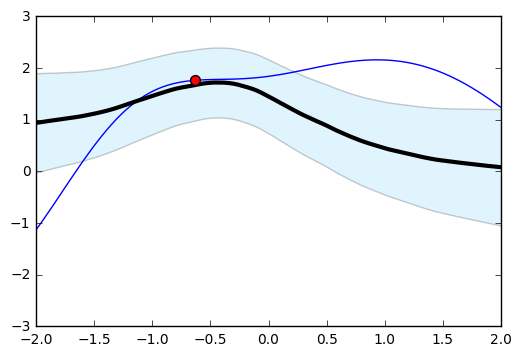

0.4840783
0.32867134
0.3445227
-0.014157985
0.6301536
0.084508866
0.6182986
0.60685575
0.1597777
0.9547425


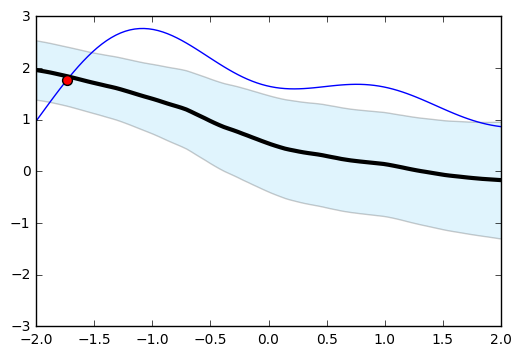

0.46289676
1.0731174
1.6236572
0.5354766
0.045994837
1.0667318
0.79135096
1.4531924
1.0204682
0.656754


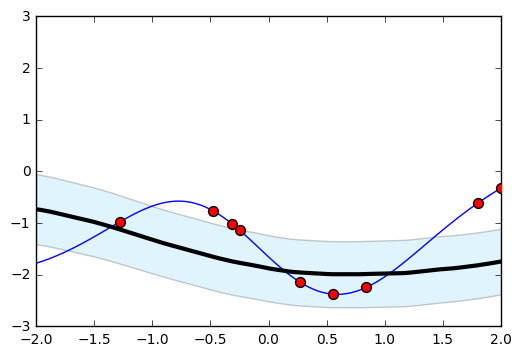

-0.040891413
-0.058229953
1.3651898
0.16460197
-0.10012491
0.5330977
0.5197883
0.4135581
0.19818039
0.8289428


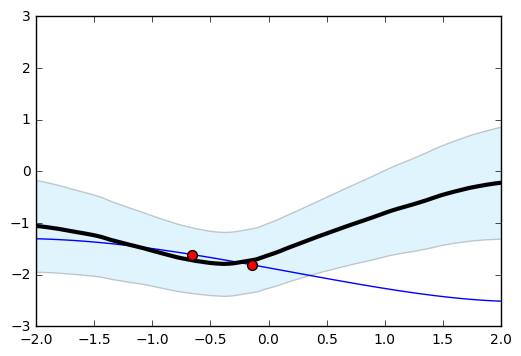

0.2892669
0.66952455
0.5611015
0.12641095
0.50446194
-0.15829238
0.825459
0.2541401
0.44016978
0.19200642


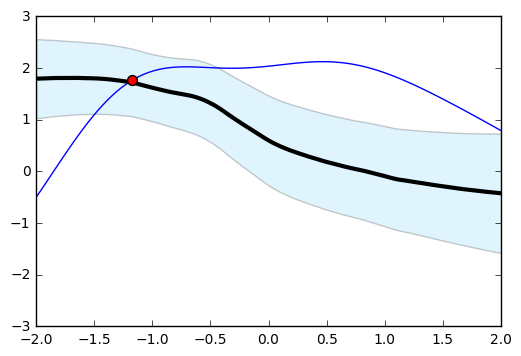

-0.29771212
0.9682516
0.84274524
0.49204355
0.5649891
0.6195172
0.30943
0.8150197
0.81524986
0.45563015


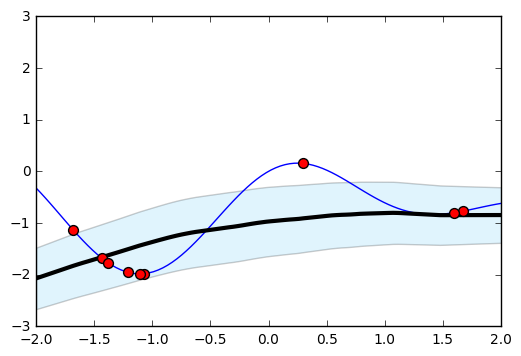

0.4855459
0.08793025
0.1715397
0.2789234
1.0881367
0.8052268
0.33491266
0.75919926
1.0702161
0.5175768


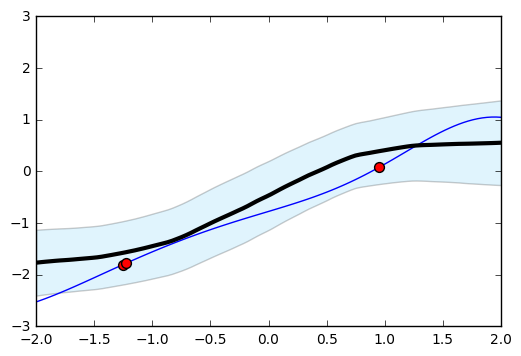

0.5573372
1.3896011
0.8112031
0.35522056
0.95017153
-0.028949847
0.83469486
0.6738281
0.7276474
0.5785112


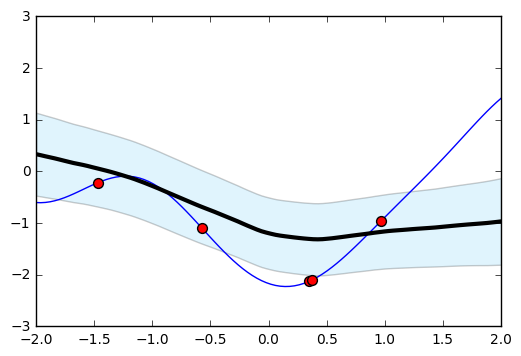

1.658938
0.14055063
1.9059644
0.27256092
1.2633365
1.1121699
0.3281047
0.058111113
0.1717795
-0.12033875


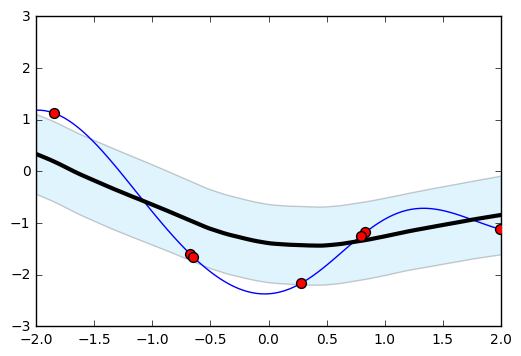

0.8392619
0.43145236
0.40822047
-0.3474141
0.70734507
0.16888003
0.31001803
-0.2151554
0.11049989
0.79764473


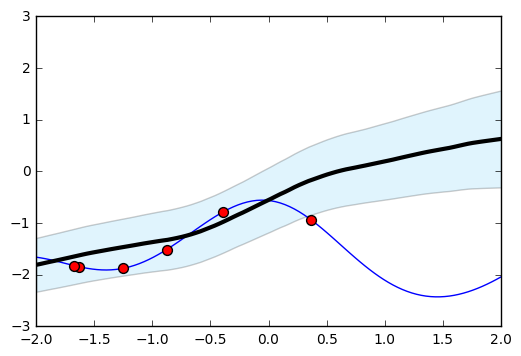

0.6368426
0.12587687
0.99513346
0.7094668
1.1562301
0.7506492
0.034478236
0.27560347
1.0688474
0.4030468


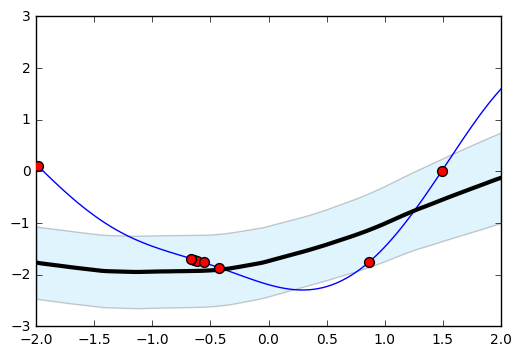

-0.10544545
-0.14816177
0.51374
0.30435774
0.3350028
0.35352483
-0.23114634
0.8658317
0.910334
1.1672829


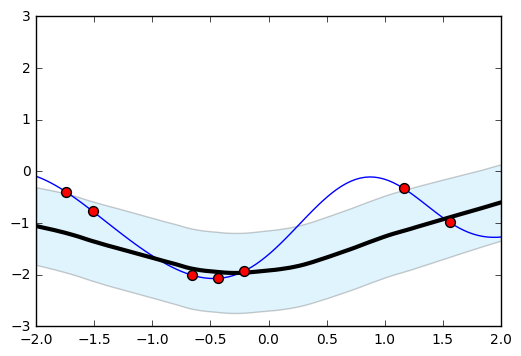

0.124638066
-0.13421112
0.60560405
0.15624739
0.4779312
0.03922987
1.2892927
0.54381907
0.4837195
0.74092025


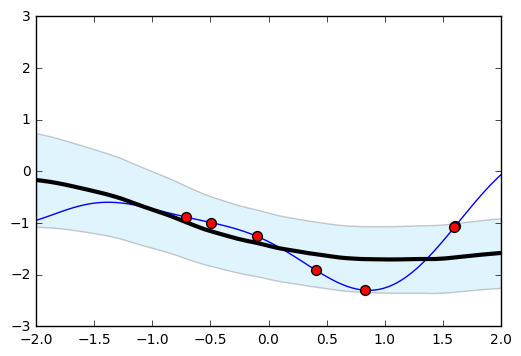

0.5693745
0.8810322
0.4532101
0.6534308
0.33287394
0.56721145
1.0775965
0.29096127
1.1377603
0.3477397


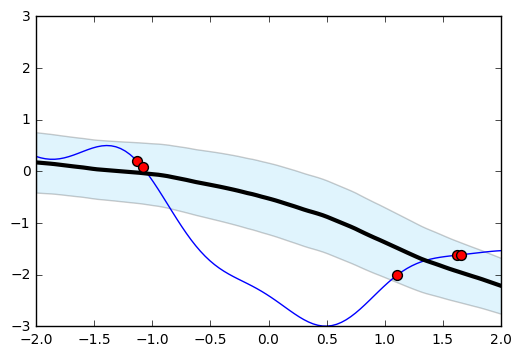

0.468735
0.4497724
0.41355982
-0.12909898
0.20452285
0.3386656
1.1664532
0.7956177
0.9738417
0.27821082


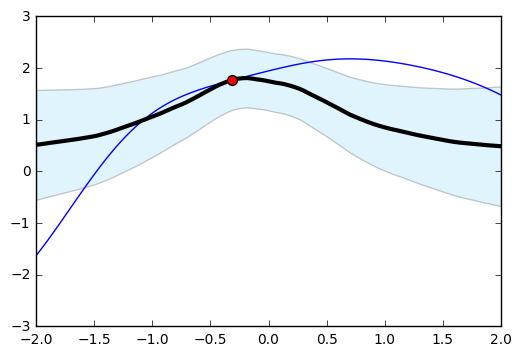

0.39384276
0.25604275
0.15790246
1.1656213
0.443026
0.88420653
1.0119518
0.05300592
0.14931498
-0.015221668


/Users/fanfan/anaconda/envs/dlnd-tf-lab/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-2.0735355]), 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)


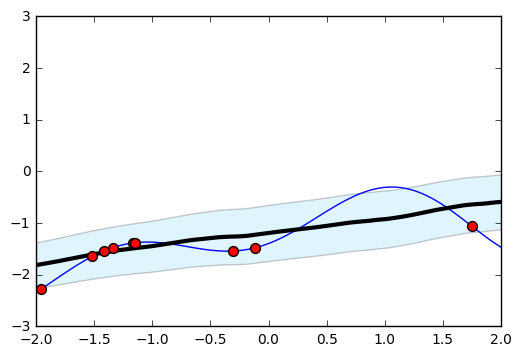

0.83797985
0.056298133
-0.058004934
0.7129052
0.34337905
1.039215
0.5295835
0.74761397
0.60682243
0.19926186


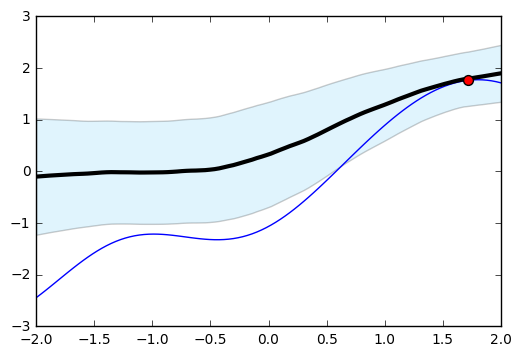

0.7872304
0.99954224
0.8322483
0.8642358
0.624307
1.1432949
0.88299406
1.8388098
0.7583146
0.14087678


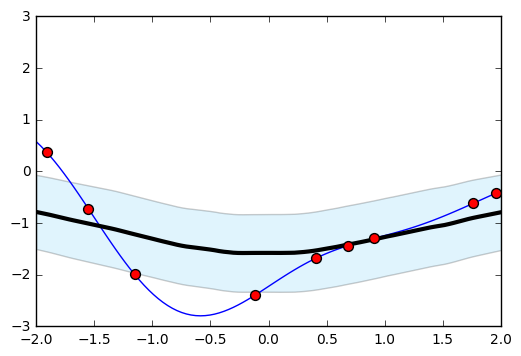

0.7723983
0.2432318
0.72667617
0.07259067
0.7607927
0.1744102
-0.18990082
1.6009587
1.5114866
1.3116271


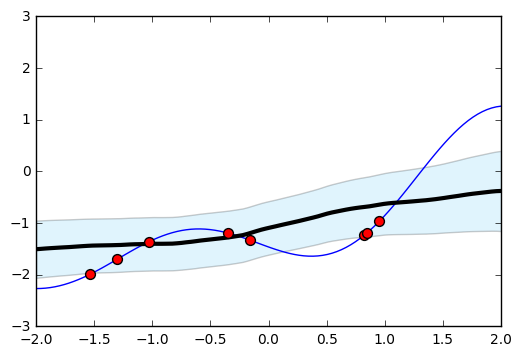

0.24918985
-0.05839032
1.1837988
0.013031876
0.53417766
0.34859535
-0.15098906
1.897521
0.15889078
-0.0417378


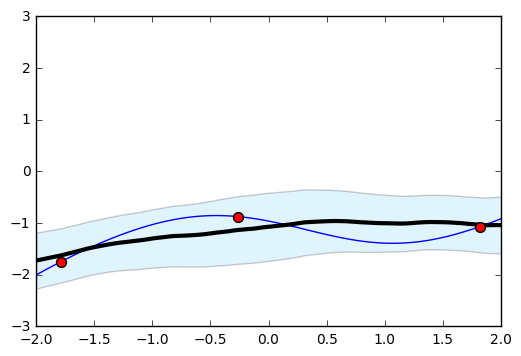

0.53834957
1.6403764
-0.040358767
1.0595442
0.48508227
0.62474793
0.7455772
1.2212372
0.47847652
1.410553


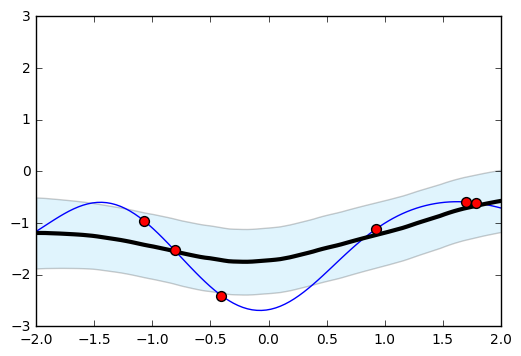

0.64696056
0.18942137
0.12592873
0.07681412
0.3448776
1.2267878
2.4864767
1.3815193
0.45073032
0.35656524


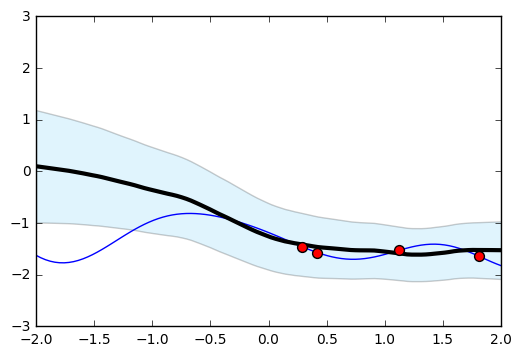

0.9781937
0.025563579
0.5854169
1.0331919
1.6905375
1.1008
0.73441446
-0.09169251
-0.087671675
-0.14379002


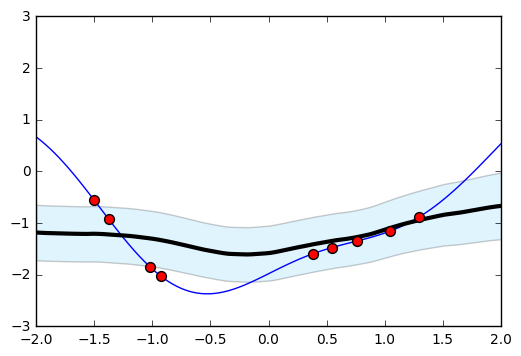

0.48915595
0.30732656
0.47503892
0.6304801
0.063202105
0.9283012
0.29219973
0.6513143
0.0018493588
0.70789707


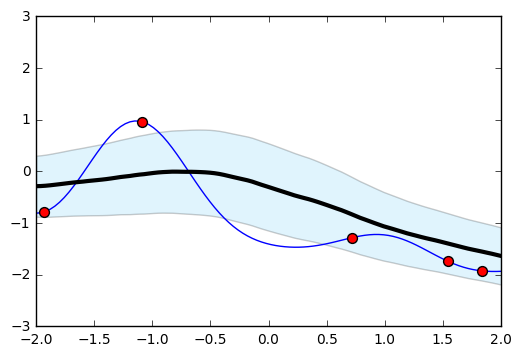

0.8458364
0.16884491
0.36192018
0.7846153
6.6552167
0.19155796
0.6692933
1.0645452
0.39637688
0.65009385


/Users/fanfan/anaconda/envs/dlnd-tf-lab/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-5.82002103e-05]), 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


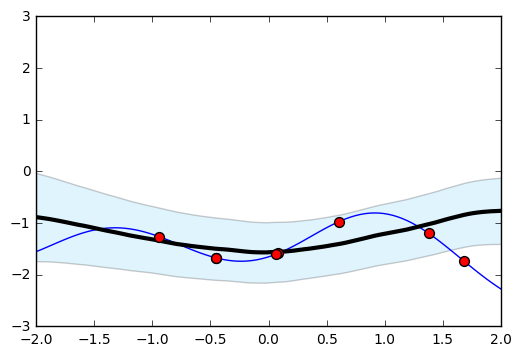

0.29211098
0.66247207
1.378783
0.448998
0.48223695
0.60655075
0.23201041
0.02409773
0.27065653
0.8247879


/Users/fanfan/anaconda/envs/dlnd-tf-lab/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00215527]), 'funcalls': 76, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


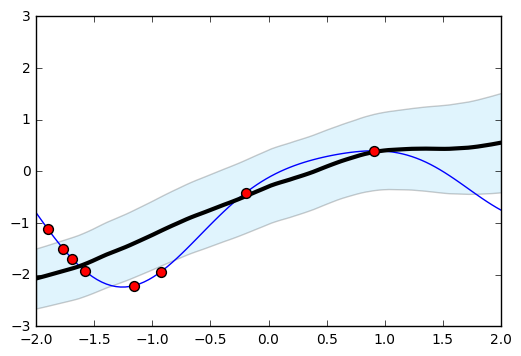

0.70049804
0.39606884
0.8031112
0.8273772
-0.17716616
-0.002327269
0.7865042
0.9044169
1.8109131
0.409917


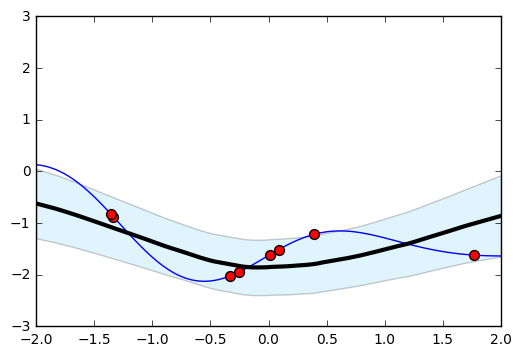

0.18008737
-0.1617572
0.026190177
1.825317
1.1214484
0.28986984
0.5907501
0.50821614
1.5108335
0.6391218


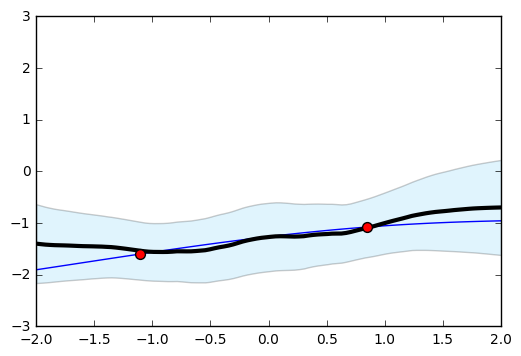

0.40157625
0.22446768
0.16610426
0.38758457
0.5462906
0.8714259
1.9280431
0.18907607
0.86878204
0.80799496


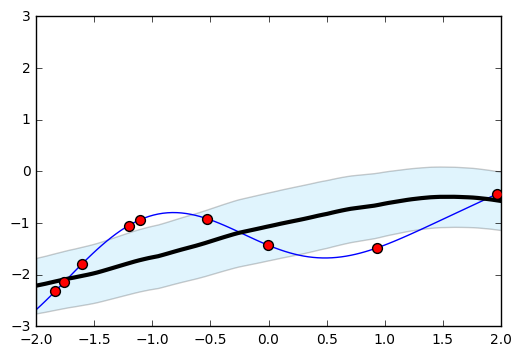

0.5193733
0.15435685
0.029857073
0.8583426
1.7073935
0.17858957
-0.10805603
0.12349762
1.2583832
1.0044935


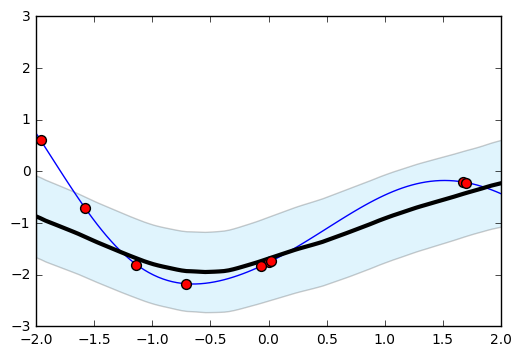

0.42374715
1.054103
1.0954052
0.2280099
0.6168311
0.55596167
1.0290177
1.2984431
1.6792055
0.50752527


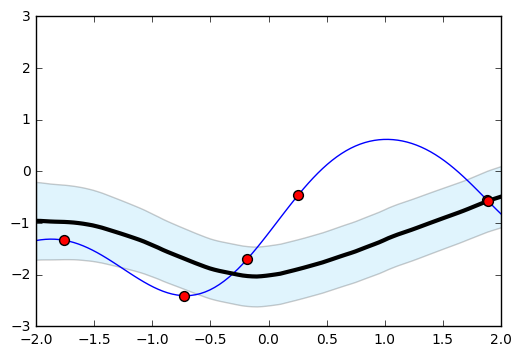

0.42511082
-0.16668068
0.13801546
0.520838
0.70272446
1.0061615
0.6484897
0.25748035
1.0589622
0.99969745


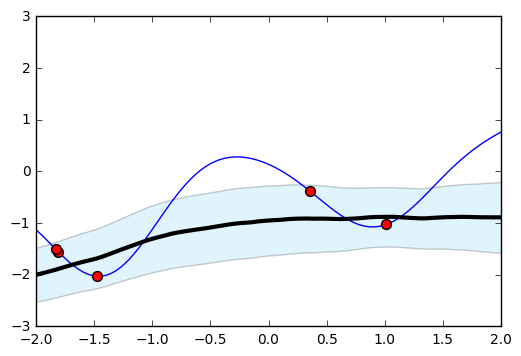

1.4230715
0.3495577
0.58595484
0.7450502
0.7213797
0.65513533
1.358972
1.1716084
2.3461685
0.5342157


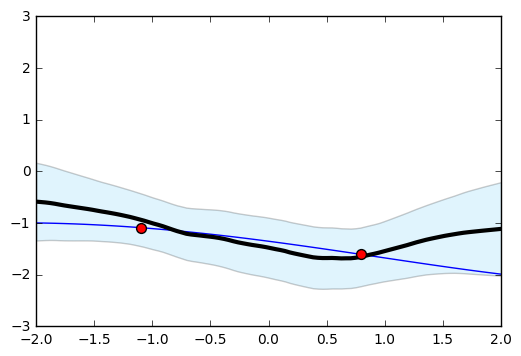

0.78055596
0.6539669
2.2496488
0.47176275
0.2012376
0.6238271
0.6373282
0.042138815
0.14849742
0.9146769


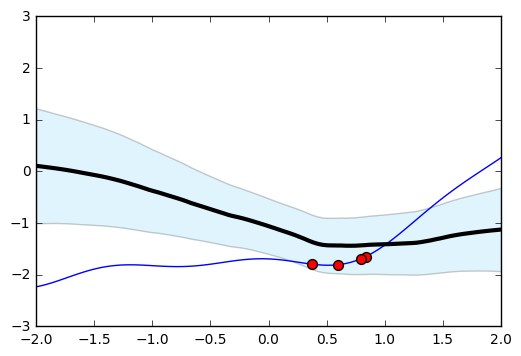

0.51486456
0.07179431
0.95398045
0.7387863
0.5793655
0.52641404
1.9973263
0.1613253
0.3108039
1.0188588


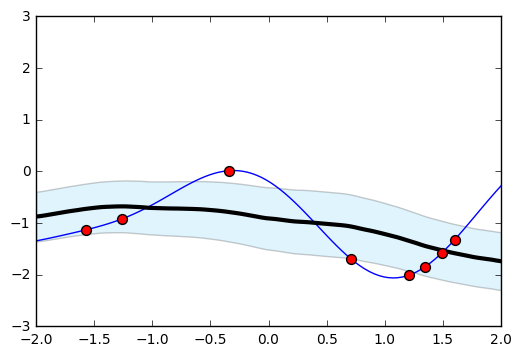

0.34302363
0.6448173
0.25826108
0.75760365
0.1991165
0.457713
-0.04587271
0.06384054
0.85287696
1.869297


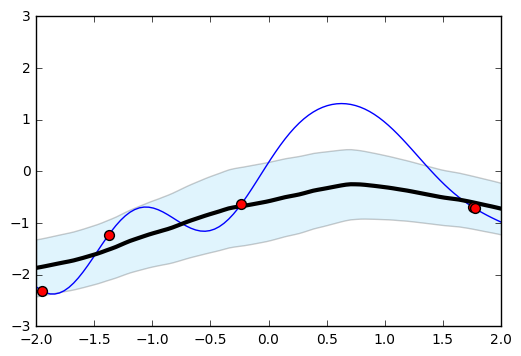

0.48490828
0.69609946
0.37348723
-0.18911415
0.2746314
0.8324046
0.62514853
0.2416305
0.22146337
0.69132787


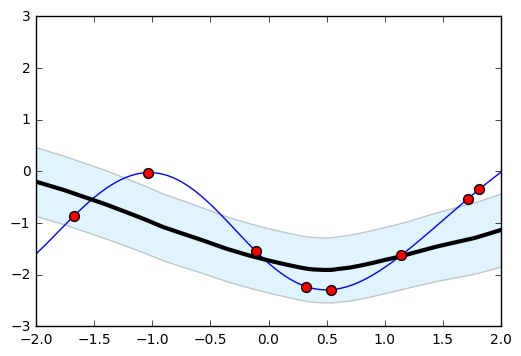

0.033572976
0.22288886
1.145772
0.27696162
0.6884891
0.8336685
0.48825628
0.020119395
0.7304116
-0.29072255


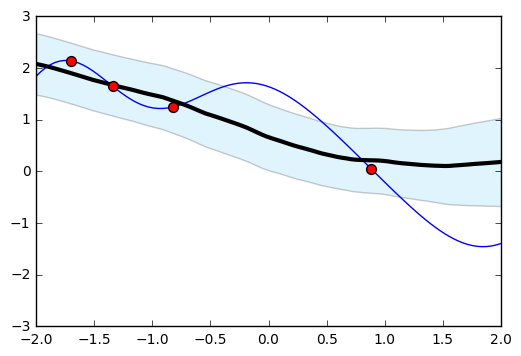

0.31775326
0.4951352
0.7662448
0.2724104
0.51042837
1.2726964
0.5677411
0.33542332
1.5494646
1.0209576


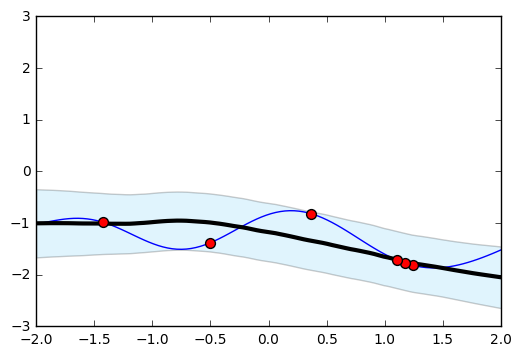

0.6531464
0.58292615
0.35992324
2.0822234
0.24294677
0.30695698
0.08127235
1.2128083
1.24287
0.8256957


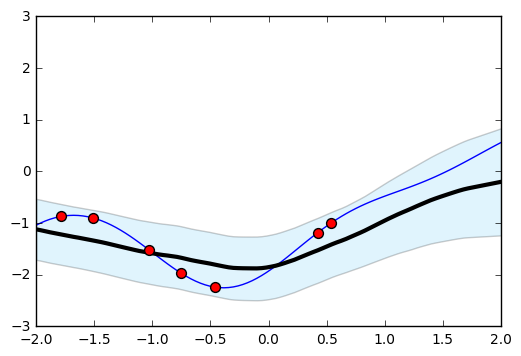

0.85266733
0.5808918
0.6525396
0.39977905
0.608025
0.9088765
0.9335707
-0.112080246
0.9167759
0.98491514


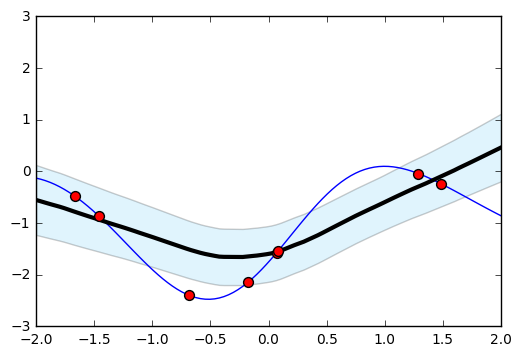

0.42230085
0.37817404
0.7023108
2.0181968
0.5217276
0.1609448
1.7681428
0.15286705
1.7836788
0.54791504


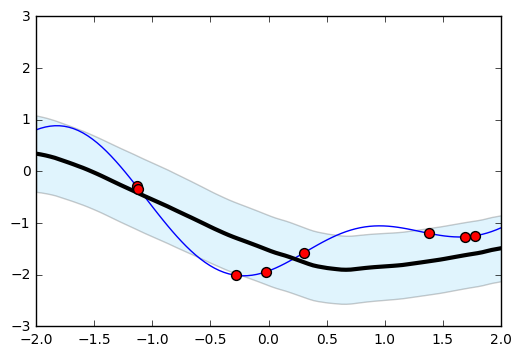

0.06079936
-0.024538355
-0.22072722
0.281719
0.39824933
-0.024100041
1.1727159
0.2773938
0.22288132
0.8106393


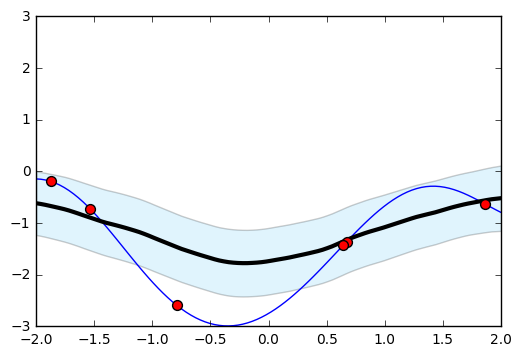

0.9023275
0.9136985
0.5316518
-0.118978225
0.51581746
-0.00043220818
0.61491334
0.17166221
3.7013357
0.39507464


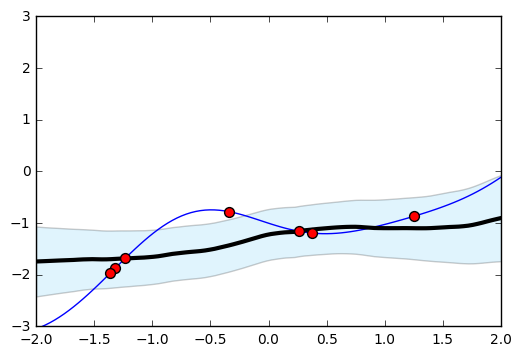

0.40989488
1.3605999
0.20604183
0.5135278
0.12363747
-0.17444406
0.13712409
0.6554549
0.31699926
0.15105452


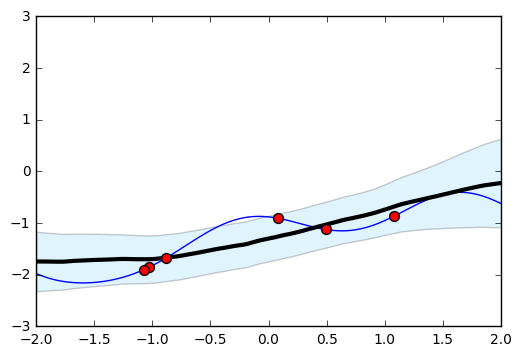

0.95481175
0.072972715
0.3187227
0.9966981
0.5055986
0.5076515
0.71555066
0.0005108714
0.27587217
0.7217601


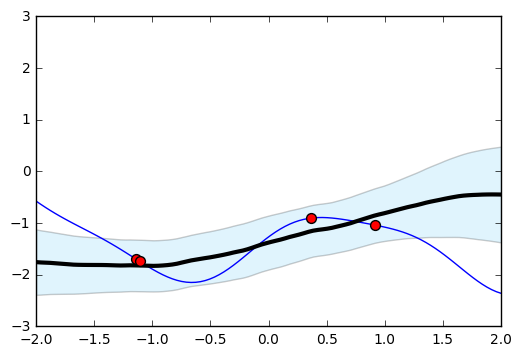

-0.41212267
1.3977222
0.7715386
0.20944902
0.53676206
0.3054058
0.77282155
0.24153885
0.9588796
0.4461702


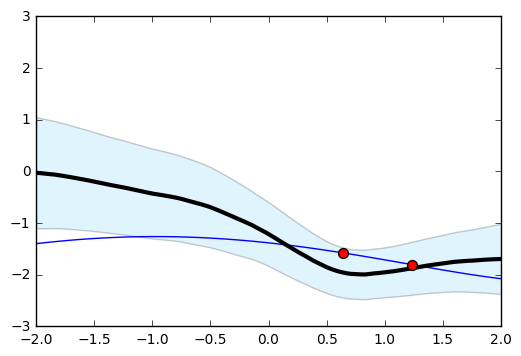

1.5062051
0.59254515
0.6046642
2.6609802
0.60004884
0.032477252
0.46985435
0.53392434
0.025918048
-0.06415289


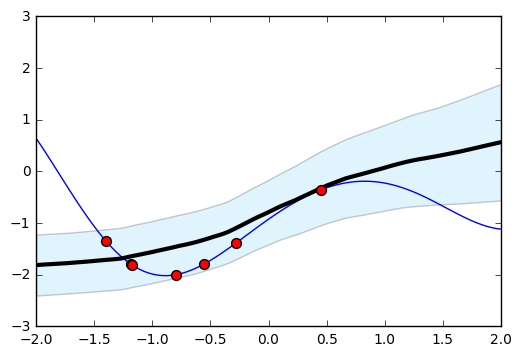

-0.08361452
0.7572601
-0.14078096
0.6355804
-0.09519638
0.6296787
0.5069688
2.2986083
0.22889446
-0.07187802


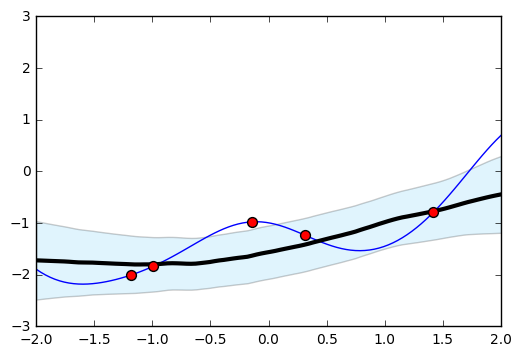

0.5851045
1.9124912
0.49471936
0.35180712
0.38172567
0.3063407
-0.09685734
2.064581
1.7843515
0.716614


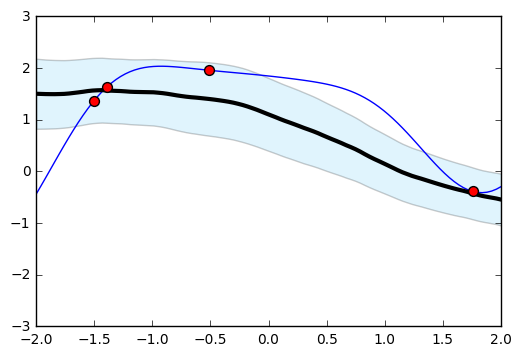

0.74037254
1.0767815
-0.16958433
0.1314049
0.017530859
0.055883516
-0.30078936
0.40549672
0.118153706
0.31137532


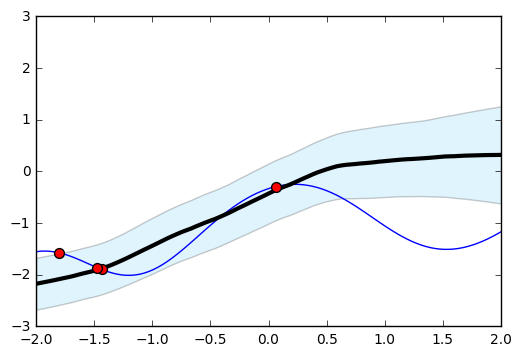

0.5243014
0.4284813
0.047969736
0.8664458
2.616745
0.49532592
0.943159
-0.260972
0.47238156
0.6594419


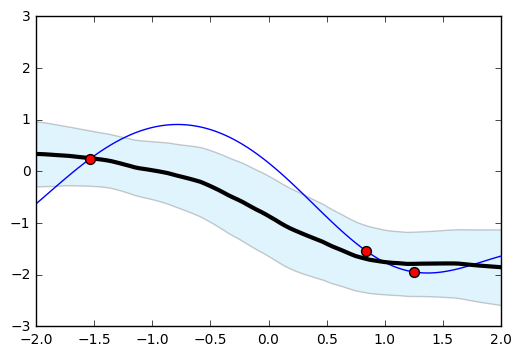

0.8279516
0.36318812
0.087092966
0.059220873
-0.17989266
-0.17984438
0.96686757
0.57843995
-0.03475472
0.57325834


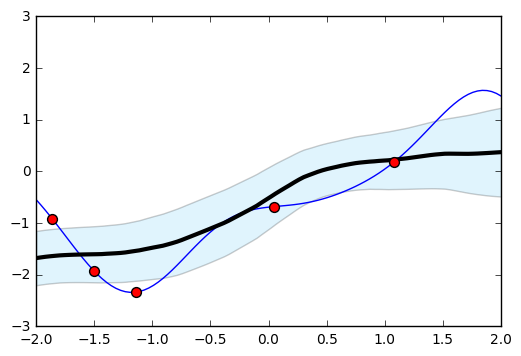

0.9019627
0.21411231
0.46858934
0.3084441
0.7920197
1.0310602
0.30569592
0.61994517
0.070930056
0.01046162


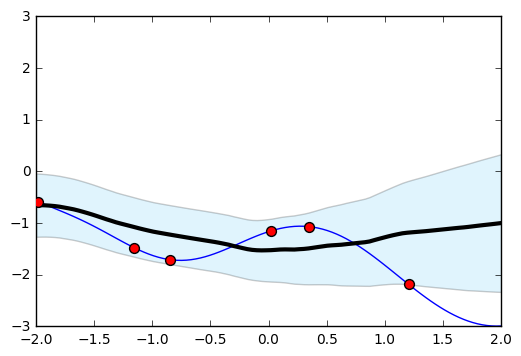

0.05130337
0.2697707
0.6030714
-0.12597753
0.370358
0.9952277
0.70441306
0.73782575
0.31872246
0.6121516


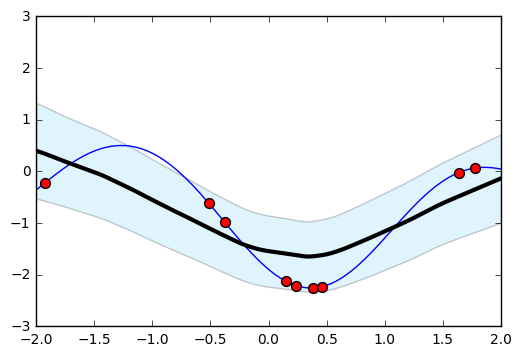

1.5004452
0.28328353
1.0136324
-0.28113967
0.33730313
0.4663069
0.451082
0.18113779
1.5506755
-0.08296841


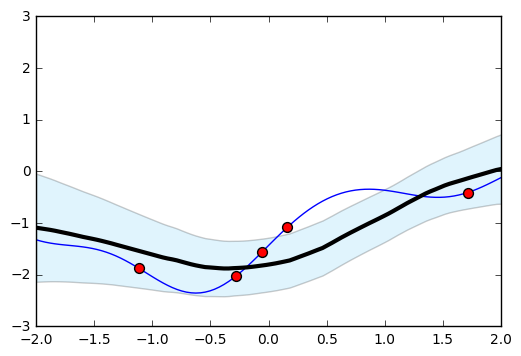

0.3224451
0.7761109
1.1885566
0.59941447
-0.059565652
-0.031938035
0.32447073
0.4427707
0.38481146
0.3022098


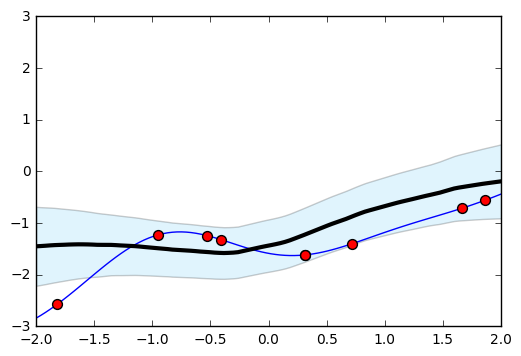

-0.27098045
1.1567624
0.18819244
0.6932083
-0.32393894
1.2137384
1.358262
-0.10479613
-0.22851515
-0.014286433


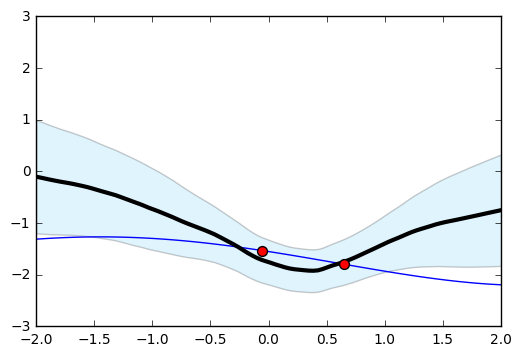

0.59729075
2.6611674
0.41921037
0.052878562
0.44833678
-0.13995638
0.41100705
0.75839615
0.41379917
0.73911315


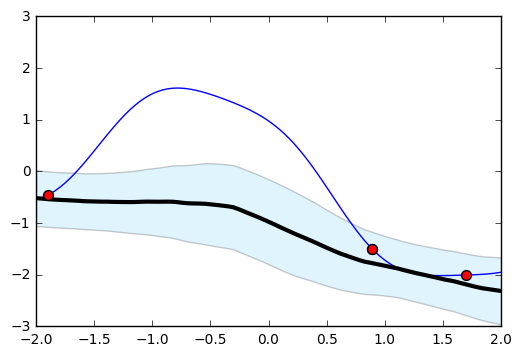

0.7118117
-0.12018422
0.2659269
0.19932294
0.8210681
0.6469262
0.5834779
0.42134672
1.3657899
0.6624626


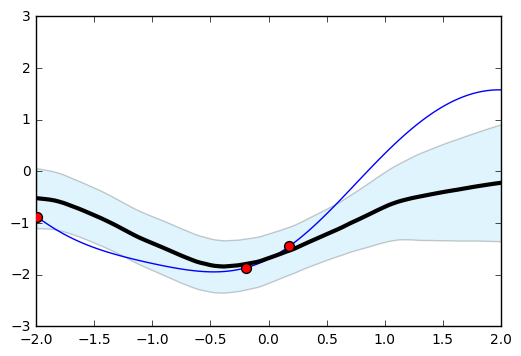

0.02989753
0.4346637
0.47023144
-0.36505693
0.47805378
-0.42214555
0.36895308
0.5147335
-0.18690948
0.1554762


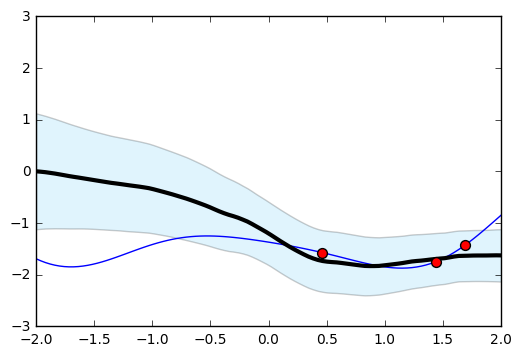

1.2923372
0.47576517
-0.08584883
0.9347909
-0.15141742
-0.20446403
1.4802732
0.57360893
0.35434538
0.14534822


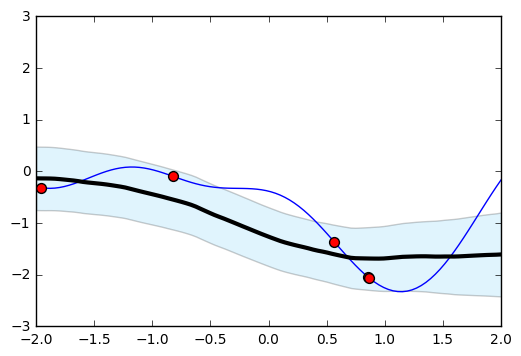

0.16867582
1.759771
0.44853622
0.54963326
0.8335221
0.6140438
0.66206235
1.6528939
0.5497716
0.48349214


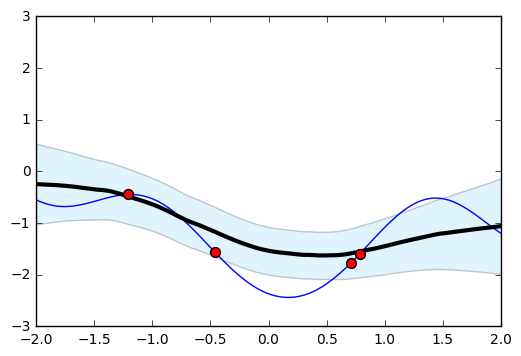

0.33814347
0.27889296
0.33303252
-0.11442051
0.25481623
1.496588
1.4561523
-0.037275914
0.07694515
0.09777219


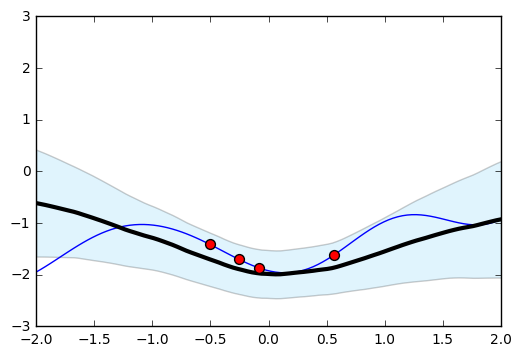

1.0391345
0.9392456
1.0173621
-0.09313694
0.58647496
-0.4332308
0.1742389
0.41748002
-0.3286695
-0.04716031


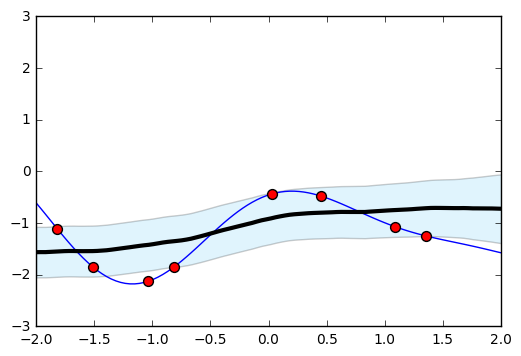

-0.14060667
0.16669872
0.46465784
0.6166408
-0.1838507
0.11189119
0.72375315
0.19870636
0.7385007
0.45604458


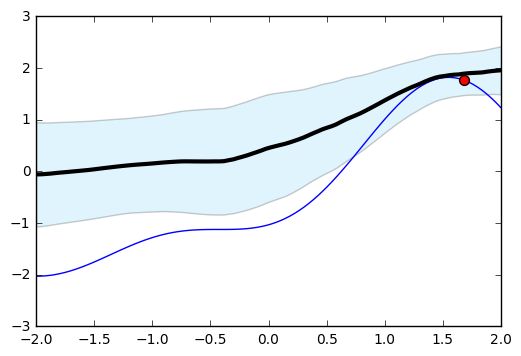

0.58659095
0.25306162
0.54485106
0.8059408
1.0400555
0.9443305
0.5669813
0.4454904
0.29062468
-0.012737359


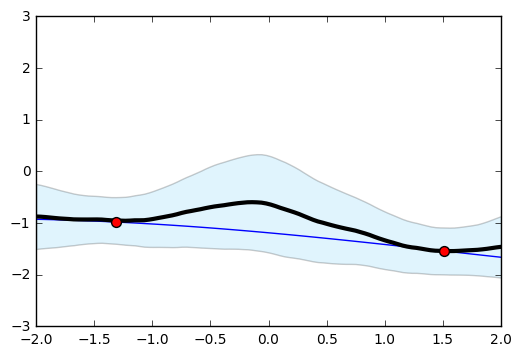

-0.15164131
0.71728927
-0.05855475
0.70492685
0.7191908
0.34591213
0.85683244
1.3668654
-0.048437253
0.7081446


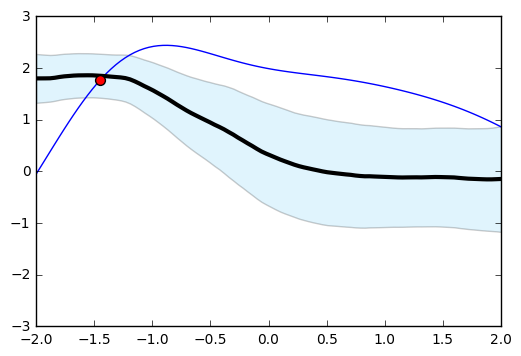

1.3962282
1.218163
0.9735508
0.3726274
-0.3164641
0.07016928
0.7799002
0.5899582
0.30445683
1.2792982


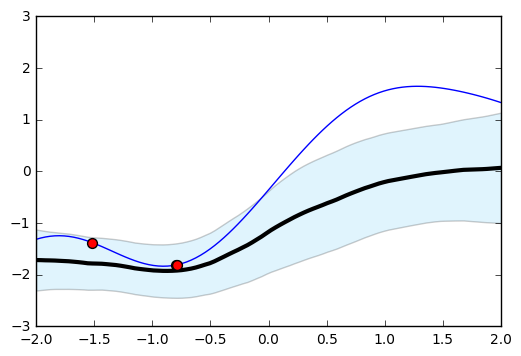

0.39143053
0.40332082
0.34246516
3.7755744
0.6898229
0.3802257
0.037305363
0.6364781
0.749219
0.38026056


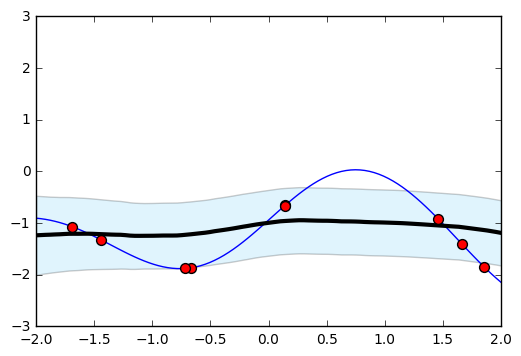

1.0358812
0.38761136
-0.039927274
-0.05644179
-0.04993938
0.61234725
0.032734547
0.4904965
1.1077477
0.6116457


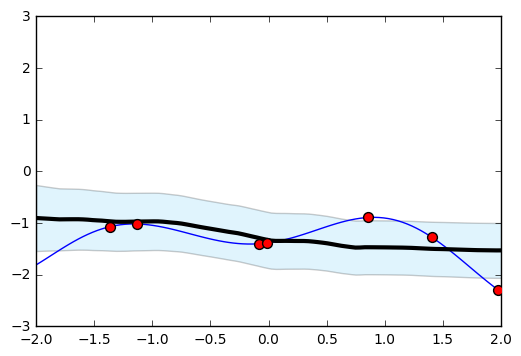

0.13527998
0.82575387
0.588572
-0.060859382
0.57370436
0.63136154
0.006225509
0.55524826
-0.40383896
0.11253852


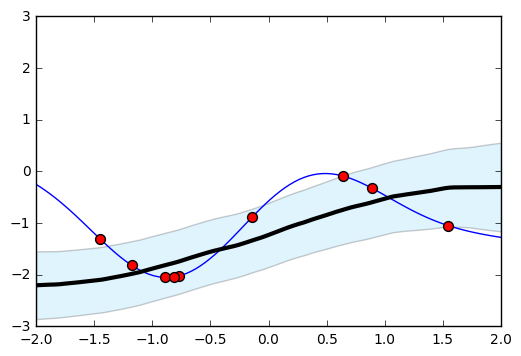

0.8379886
0.58189505
0.21813072
0.4004497
1.191884
-0.17114843
0.4938585
0.35798788
-0.16785271
-0.43082199


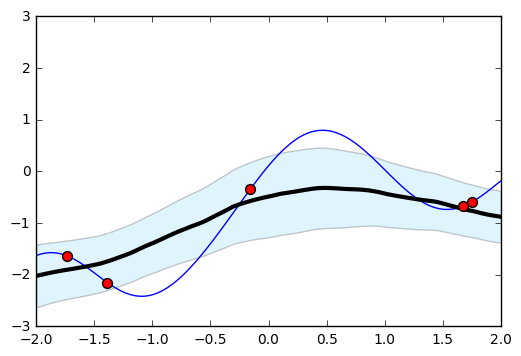

0.724567
-0.0639898
-0.06735001
0.49534073
0.06858901
0.23988353
0.65203583
1.0679145
0.50994384
-0.06783015


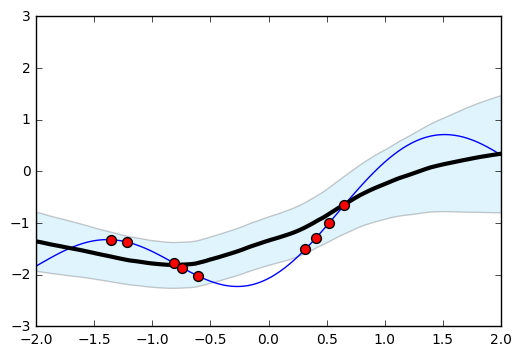

0.5667044
0.27900994
0.113287956
1.0343843
-0.2321119
0.6481258
0.47835928
0.087232225
-0.48889038
0.115428925


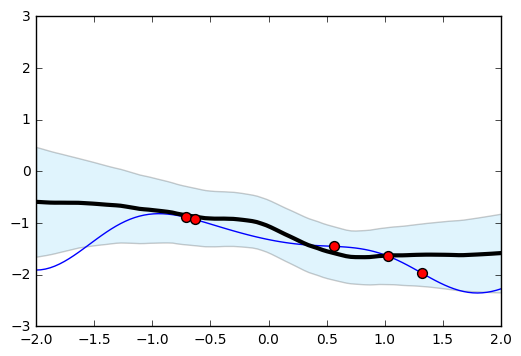

1.06411
1.0123336
0.25413457
0.21700343
0.4361652


KeyboardInterrupt: 

In [21]:
n_epoch = 1000000
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
gp_test = GaussianProcessRegressor(kernel=kernel)
encoder_test_select, X_, X_test, y_test = generate_test_data()
gp_test.fit(X_test,y_test)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(n_epoch):
    encoder_input_select, X, Y = generate_data()
    feed_dict = {
        encoder_input: encoder_input_select,
        decoder_input: X,
        decoder_output: Y
    }
    l, _ = sess.run([loss, optimizer], feed_dict = feed_dict)
    if i % 100 == 0:
        print(l)
    if i%1000 ==0:
        encoder_test_select, X_, X_test, y_test = generate_test_data()
        gp_test.fit(X_test,y_test)
        feed_dict = {encoder_input: encoder_test_select, decoder_input: X_.reshape(-1,1)}
        y_mean, y_var = sess.run([decoder_mean, decoder_var], feed_dict = feed_dict)
        y_std = np.sqrt(y_var)
        plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
        plt.fill_between(X_, y_mean.reshape(-1) - y_std.reshape(-1), y_mean.reshape(-1) + y_std.reshape(-1),
                 alpha=0.2, facecolor='#65c9f7', interpolate=True)
        y_samples = gp_test.sample_y(X_[:, np.newaxis], 1)
        plt.plot(X_, y_samples, lw=1)
        plt.scatter(X_test[:, 0], y_test, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
        plt.xlim(-2, 2)
        plt.ylim(-3, 3)
        plt.show()